<a href="https://colab.research.google.com/github/mdersu/Projects/blob/main/Portfolio_Backtest__Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install

In [ ]:
!pip install yfinance
!pip install talib
!pip install hmmlearn
!pip install TA-Lib
!pip install ta
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
!pip install matplotlib


ERROR: Could not find a version that satisfies the requirement talib (from versions: none)
ERROR: No matching distribution found for talib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.6/369.6 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for TA-Lib
Failed to build TA-Lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (TA-Lib)
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=cee1b2112529d82c42220ec7d253997c59

#Efficient indicators Chain

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
import talib as ta
import os
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter


In [ ]:
#tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "SOFI", "PLTR", "KRRO", "BLK", "AMZN", "AVGO", "JPM", "LLY"]
tickers = ["BABA", "JD", "FOUR", "BIDU", "MOH", "OLPX", "REAL", "ACIC", "HPP", "BCAB"]

start_date = '2020-01-01'
end_date = '2024-10-31'
interval = '1d'
lookback = 60
fred_api_key = "4900ff387674e4637fb09b7e6fe5faf8"

    # File and folder paths
features_folder = "/content"
targets_folder = "/content"
output_features_folder = "/content/merged_features"
output_targets_folder = "/content/merged_targets"
output_folder = "/content/ticker_models"  # Corrected to match references in your scripts

    # Model and training parameters
n_window_size = 20
n_neurons = 200
n_layers = 2
learning_rate = 0.001
n_epochs = 15
batch_size = 15
initial_balance = 100000

    # Combined features and targets files
features_file = "merged_features/combined_features.csv"
targets_file = "merged_targets/combined_targets.csv"

    # Fundamental data paths
fundamental_data_path = "/content/drive/MyDrive/Colab Data/DATA WRDS/wrdsapps_finratio.csv"
metrics_file = "/content/drive/MyDrive/Colab Data/DATA WRDS/selected_financial_metrics_list.csv"
macro_file = "/content/drive/MyDrive/Colab Data/DATA WRDS/macro_data.csv"

In [ ]:
def variables():
    """
    Returns a dictionary of key configuration variables used throughout the system.
    """
    #tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA", "SOFI", "PLTR", "KRRO", "BLK", "AMZN", "AVGO", "JPM", "LLY"]
    tickers = ["BABA", "JD", "FOUR", "BIDU", "MOH", "OLPX", "REAL", "ACIC", "HPP", "BCAB"]

    start_date = '2020-01-01'
    end_date = '2024-10-31'
    interval = '1d'
    lookback = 60
    fred_api_key = "4900ff387674e4637fb09b7e6fe5faf8"

    # File and folder paths
    features_folder = "/content"
    targets_folder = "/content"
    output_features_folder = "/content/merged_features"
    output_targets_folder = "/content/merged_targets"
    output_folder = "/content/ticker_models"  # Corrected to match references in your scripts

    # Model and training parameters
    n_window_size = 20
    n_neurons = 200
    n_layers = 2
    learning_rate = 0.001
    n_epochs = 15
    batch_size = 15
    initial_balance = 100000

    # Combined features and targets files
    features_file = "merged_features/combined_features.csv"
    targets_file = "merged_targets/combined_targets.csv"

    # Fundamental data paths
    fundamental_data_path = "/content/drive/MyDrive/Colab Data/DATA WRDS/wrdsapps_finratio.csv"
    metrics_file = "/content/drive/MyDrive/Colab Data/DATA WRDS/selected_financial_metrics_list.csv"
    macro_file = "/content/drive/MyDrive/Colab Data/DATA WRDS/macro_data.csv"
    return locals()

In [ ]:
def load_and_preprocess_data(tickers, existing_file=None, lookback=lookback):
    """
    Loads and preprocesses data for a list of tickers with a specified lookback period.
    Fetches all necessary variables dynamically from the `variables` function.

    Returns:
        dict: A dictionary containing preprocessed DataFrames for each ticker.
    """
    import yfinance as yf
    import pandas as pd
    from datetime import timedelta
    import logging

    # Fetch variables from the variables() function
    vars = variables()
    tickers = vars['tickers']
    start_date = vars['start_date']
    end_date = vars['end_date']
    interval = vars['interval']
    lookback = vars['lookback']

    # Initialize logger
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    data = {}

    for ticker in tickers:
        logger.info(f"Fetching data for {ticker} from Yahoo Finance.")

        # Download the main dataset
        df = yf.download(ticker, start=start_date, end=end_date, interval=interval)

        # Ensure the dataset includes the lookback period
        if not df.empty:
            earliest_date = df.index[0]
            lookback_start_date = (earliest_date - pd.Timedelta(days=lookback)).strftime('%Y-%m-%d')

            # Download additional lookback data
            lookback_df = yf.download(ticker, start=lookback_start_date, end=earliest_date, interval=interval)
            df = pd.concat([lookback_df, df]).drop_duplicates()

        # Clean and preprocess the data
        df.dropna(inplace=True)
        df.reset_index(inplace=True)  # Resets index and adds 'Datetime' as a column
        df['Ticker'] = ticker

        # Round numerical data to avoid precision issues
        df = df.round(5)

        # Save individual ticker data for debugging or future use
        file_name = f"{ticker}_data.csv"
        df.to_csv(file_name, index=False)
        logger.info(f"Saved raw data for {ticker} with lookback to {file_name}.")
        df.rename(columns={'datetime': 'Datetime'}, inplace=True)
        df.rename(columns={'Date': 'Datetime'}, inplace=True)

        # Store in dictionary
        data[ticker] = df

    return data


data = load_and_preprocess_data(tickers, existing_file=None, lookback=lookback)


def verify_data(data):
    """
    Verifies and cleans the downloaded and preprocessed data.
    Args:
        data (dict): A dictionary containing preprocessed DataFrames for each ticker.

    Returns:
        None
    """
    logger = logging.getLogger(__name__)

    # Processed data verification
    for ticker, df in data.items():
        logger.info(f"Processed data for {ticker} with lookback:\n{df.head()}")

    # Verify and clean individual files
    for file in os.listdir():
        if file.endswith("_data.csv"):
            df = pd.read_csv(file)

            # Print the original column names for verification
            logger.info(f"Original columns in {file}: {df.columns.tolist()}")

            # Rename 'Price' to 'Datetime' if needed
            if 'Datetime' not in df.columns and 'Price' in df.columns:
                df.rename(columns={'Price': 'Datetime'}, inplace=True)
                logger.info(f"Renamed 'Price' to 'Datetime' in {file}.")

            # Remove rows with NaN values in the 'Adj Close' column
            if 'Adj Close' in df.columns:
                initial_row_count = df.shape[0]
                df.dropna(subset=['Adj Close'], inplace=True)
                final_row_count = df.shape[0]
                logger.info(f"Removed {initial_row_count - final_row_count} rows with NaN values in 'Adj Close' from {file}.")
            df.rename(columns={'Date': 'Datetime'}, inplace=True)

            # Save the modified DataFrame
            df.to_csv(file, index=False)

    # Confirm the changes by printing the updated column names and row counts
    for file in os.listdir():
        if file.endswith("_data.csv"):
            df = pd.read_csv(file)
            logger.info(f"Updated columns in {file}: {df.columns.tolist()}")
            logger.info(f"Remaining rows in {file}: {df.shape[0]}")

    # Remove the first row (index 0) and add 'Ticker' column
    for file in os.listdir():
        if file.endswith("_data.csv"):
            ticker = file.split("_data.csv")[0]
            df = pd.read_csv(file)

            if len(df) > 1:
                df.drop(index=0, inplace=True)

            df['Ticker'] = ticker
            df.to_csv(file, index=False)
            df.rename(columns={'datetime': 'Datetime'}, inplace=True)
            df.rename(columns={'Date': 'Datetime'}, inplace=True)

            # Print verification
            logger.info(f"Updated columns in {file}: {df.columns.tolist()}")
            logger.info(f"Head of the file:\n{df.head()}")


verify_data(data)

INFO:__main__:Fetching data for BABA from Yahoo Finance.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INFO:__main__:Saved raw data for BABA with lookback to BABA_data.csv.
INFO:__main__:Fetching data for JD from Yahoo Finance.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INFO:__main__:Saved raw data for JD with lookback to JD_data.csv.
INFO:__main__:Fetching data for FOUR from Yahoo Finance.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FOUR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-04-06 -> 2020-06-05 00:00:00+00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1586145600, endDate = 1591315200")')
INFO:__main__:

In [ ]:
def calculate_indicators(tickers):
    import talib as ta
    import pandas as pd
    import os

    # Define the maximum lookback period for indicators
    MAX_LOOKBACK = 60  # Adjust based on the longest timeperiod used in your indicators

    for ticker in tickers:
        print(f"Starting analysis for {ticker}...")

        # Load the ticker's data file
        file_name = f"{ticker}_data.csv"
        if not os.path.exists(file_name):
            print(f"{file_name} does not exist. Skipping...")
            continue

        # Load and preprocess the DataFrame
        df = pd.read_csv(file_name)
        df = df.copy()  # Create a copy to avoid modifying the original
        df.ffill(inplace=True)  # Forward-fill missing values
        df.bfill(inplace=True)  # Back-fill missing values
        df.dropna(inplace=True)  # Remove any remaining NaN rows

        # Convert required columns to NumPy arrays
        try:
            open_price = df['Open'].to_numpy().astype(float)
            high_price = df['High'].to_numpy().astype(float)
            low_price = df['Low'].to_numpy().astype(float)
            close_price = df['Close'].to_numpy().astype(float)
            volume = df['Volume'].to_numpy().astype(float)
        except KeyError as e:
            print(f"Missing required column in {file_name}: {e}. Skipping...")
            continue
        indicators = {}

                # Overlap Studies
        indicators['DEMA'] = ta.DEMA(close_price, timeperiod=30)
        indicators['EMA'] = ta.EMA(close_price, timeperiod=30)
        indicators['KAMA'] = ta.KAMA(close_price, timeperiod=30)
        indicators['SMA'] = ta.SMA(close_price, timeperiod=30)
        indicators['T3'] = ta.T3(close_price, timeperiod=5)
        indicators['TEMA'] = ta.TEMA(close_price, timeperiod=10)
        indicators['TRIMA'] = ta.TRIMA(close_price, timeperiod=30)
        indicators['WMA'] = ta.WMA(close_price, timeperiod=30)

                # Momentum Indicators
        indicators['ADX'] = ta.ADX(high_price, low_price, close_price, timeperiod=14)
        indicators['ADXR'] = ta.ADXR(high_price, low_price, close_price, timeperiod=14)
        indicators['CCI'] = ta.CCI(high_price, low_price, close_price, timeperiod=14)
        indicators['MACD'], macdsignal, macdhist = ta.MACD(close_price, fastperiod=12, slowperiod=26, signalperiod=9)
        indicators['MOM'] = ta.MOM(close_price, timeperiod=10)
        indicators['ROC'] = ta.ROC(close_price, timeperiod=10)
        indicators['RSI'] = ta.RSI(close_price, timeperiod=14)
        indicators['STOCH_k'], indicators['STOCH_d'] = ta.STOCH(high_price, low_price, close_price)
        indicators['STOCHF_k'], indicators['STOCHF_d'] = ta.STOCHF(high_price, low_price, close_price)
        indicators['STOCHRSI_k'], indicators['STOCHRSI_d'] = ta.STOCHRSI(close_price, timeperiod=14)

                # Volume Indicators
        indicators['AD'] = ta.AD(high_price, low_price, close_price, volume)
        indicators['ADOSC'] = ta.ADOSC(high_price, low_price, close_price, volume)
        indicators['OBV'] = ta.OBV(close_price, volume)

                # Volatility Indicators
        indicators['ATR'] = ta.ATR(high_price, low_price, close_price, timeperiod=14)
        indicators['NATR'] = ta.NATR(high_price, low_price, close_price, timeperiod=14)
        indicators['TRANGE'] = ta.TRANGE(high_price, low_price, close_price)
              # Pattern Recognition
        patterns = ['CDLHAMMER', 'CDLENGULFING', 'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLDOJI']
        for pattern in patterns:
            indicators[pattern] = getattr(ta, pattern)(open_price, high_price, low_price, close_price)
              # Cycle Indicators
        indicators['HT_DCPERIOD'] = ta.HT_DCPERIOD(close_price)
        indicators['HT_DCPHASE'] = ta.HT_DCPHASE(close_price)
        indicators['HT_TRENDLINE'] = ta.HT_TRENDLINE(close_price)

                # Statistical Functions
        indicators['BETA'] = ta.BETA(high_price, low_price, timeperiod=5)
        indicators['LINEARREG'] = ta.LINEARREG(close_price, timeperiod=14)
        indicators['STDDEV'] = ta.STDDEV(close_price, timeperiod=5, nbdev=1)
        indicators['VAR'] = ta.VAR(close_price, timeperiod=5, nbdev=1)

                # Price Transform
        indicators['AVGPRICE'] = ta.AVGPRICE(open_price, high_price, low_price, close_price)
        indicators['TYPPRICE'] = ta.TYPPRICE(high_price, low_price, close_price)
        indicators['WCLPRICE'] = ta.WCLPRICE(high_price, low_price, close_price)


        # Add indicators to the DataFrame
        for name, data in indicators.items():
            if len(data) == len(df):  # Ensure the indicator's length matches the DataFrame
                df[name] = pd.Series(data).ffill()  # Convert NumPy array to pandas Series and apply ffill
            else:
                print(f"Indicator {name} has mismatched length. Skipping...")

        # Handle lookback period: Drop rows within the lookback window
        df = df.iloc[MAX_LOOKBACK:]
        df.reset_index(drop=True, inplace=True)
        df = df.round(5)
        df.ffill(inplace=True)  # Forward-fill missing values
        df.bfill(inplace=True)  # Back-fill missing values
        df.dropna(inplace=True)
        # Save the DataFrame with indicators to a new CSV file
        output_file = f"{ticker}_indicators.csv"
        df.to_csv(output_file, index=False)
        print(f"Saved data with indicators for {ticker} to {output_file}.")

    print("Completed processing for all tickers.")
    return df  # Returns the DataFrame of the last processed ticker (optional)


calculate_indicators(tickers)
def preprocess_data(ticker):
    """
    Preprocesses the data for a specific ticker from its indicators CSV file.
    Handles missing values dynamically and prepares data for modeling.
    """
    import pandas as pd
    import os

    # Load the ticker's indicators file
    file_name = f"{ticker}_indicators.csv"
    if not os.path.exists(file_name):
        print(f"{file_name} does not exist. Skipping...")
        return None, None, None

    # Load the data
    df = pd.read_csv(file_name)
    print(f"Loaded indicators data for {ticker}:")
    df.rename(columns={'datetime': 'Datetime'}, inplace=True)
    print(df.head())

    # Ensure the 'Datetime' column is preserved as a datetime object
    if 'Datetime' not in df.columns:
        print(f"'Datetime' column is missing in {file_name}. Skipping...")
        return df, [], ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

    try:
        df['Datetime'] = pd.to_datetime(df['Datetime'])
    except Exception as e:
        print(f"Error parsing 'Datetime' column for {ticker}: {e}")
        return df, [], ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

    # Define essential and indicator columns
    essential_columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close']
    default_features = ['EMA', 'RSI', 'MACD']  # Default features to include in top features
    indicator_keys = [col for col in df.columns if col not in essential_columns + default_features + ['Ticker', 'Target']]

    # Debugging
    print(f"Indicator Keys for {ticker}: {indicator_keys}")

    # Handle missing values dynamically
    df.fillna(0, inplace=True)  # Replace NaN with 0

    # Define the target variable (example: 5-day future price difference)
    df['Target'] = df['Close'].shift(-5) - df['Close']
    df.fillna(0, inplace=True)  # Replace NaN introduced by target calculation

    # Ensure sufficient rows
    if df.shape[0] < 5:
        print(f"Insufficient data for {ticker}: {df.shape[0]} rows available. Skipping...")
        return None, None, None
    'Datetime' == 'Datetime'
    return df, indicator_keys, essential_columns
df, indicator_keys, essential_columns = preprocess_data(tickers[0])
'Datetime' == 'Datetime'
print("Processed DataFrame:")
print(df.head())

import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import os
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_existing_summary(tickers, feature_dir="/content"):
    """
    Load existing top features from CSV files into a summary dictionary.
    """
    summary = {}
    for ticker in tickers:
        file_path = os.path.join(feature_dir, f"{ticker}_technical_top_features.csv")
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                # Assuming top features are the columns excluding 'Datetime' and 'Adj Close'
                top_features = [col for col in df.columns if col not in ['Datetime', 'Adj Close']]
                summary[ticker] = top_features
                logger.info(f"Loaded existing top features for {ticker} from {file_path}.")
            except Exception as e:
                logger.error(f"Error loading {file_path}: {e}")
    return summary

def efficient_indicators(tickers, feature_dir="."):
    global summary_dict
    summary_dict = load_existing_summary(tickers, feature_dir)
    results = {}  # Store results for all tickers
    default_features = ['EMA', 'RSI', 'MACD']

    def time_series_split_lstm(df, features, target, n_splits=5, n_neurons=50, n_epochs=10, batch_size=32):
        """
        Perform Time Series Split validation with LSTM model and calculate RMSE.
        """
        X = df[features].values.astype('float32')
        y = df[target].values.astype('float32')

        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_metrics = []

        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Reshape input data to 3D for LSTM [samples, time steps, features]
            X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

            # Define LSTM model
            inputs = tf.keras.Input(shape=(1, X_train.shape[2]))
            x = tf.keras.layers.LSTM(units=n_neurons, return_sequences=True)(inputs)
            x = tf.keras.layers.LSTM(units=n_neurons)(x)
            outputs = tf.keras.layers.Dense(1)(x)

            model = tf.keras.Model(inputs, outputs)

            model.compile(optimizer='adam', loss='mse')

            # Train LSTM model with validation data and early stopping
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

            # Predict on validation set
            y_pred = model.predict(X_val).flatten()

            # Calculate RMSE
            fold_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_metrics.append(fold_rmse)

        avg_rmse = np.mean(fold_metrics)
        return avg_rmse

    def rank_features(df, features, target):
        """
        Use RandomForest to rank features based on their importance in predicting the target.
        """
        X = df[features].values.astype('float32')
        y = df[target].values.astype('float32')

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        return importance_df

    for ticker in tickers:
        logger.info(f"Processing ticker: {ticker}")
        file_path = os.path.join(feature_dir, f"{ticker}_technical_top_features.csv")

        # Check if the feature file exists
        if ticker in summary_dict:
            logger.info(f"Top features for {ticker} already exist in summary_dict. Skipping calculation.")
            continue

        # Preprocess data
        try:
            df, indicator_keys, essential_columns = preprocess_data(ticker)
        except Exception as e:
            logger.error(f"Error during preprocessing data for {ticker}: {e}")
            continue

        if df is None or 'Datetime' not in df.columns:
            logger.warning(f"No data or missing 'Datetime' column for {ticker}. Skipping...")
            continue

        # Ensure 'Datetime' column is datetime and sorted
        try:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df = df.sort_values('Datetime')
        except Exception as e:
            logger.error(f"Error processing 'Datetime' for {ticker}: {e}")
            continue

        # Remove duplicate columns if they exist
        df = df.loc[:, ~df.columns.duplicated()]

        # Set target as 'Adj Close' shifted by one period
        df['Next_Period_Return'] = df['Adj Close'].shift(-1)

        # Drop rows with NaN values created by shifting
        df = df.dropna()

        # Check for sufficient features
        if not indicator_keys:
            logger.warning(f"No indicator keys found for {ticker}. Skipping...")
            continue

        # Exclude default features from filtering
        filtered_indicator_keys = [key for key in indicator_keys if key not in default_features]

        logger.info(f"Data shape: {df.shape}, Features: {len(indicator_keys)}")

        # Remove highly correlated features to increase diversity
        correlation_matrix = df[indicator_keys].corr().abs()
        upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
        highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
        diverse_features = [feature for feature in indicator_keys if feature not in highly_correlated_features]

        logger.info(f"Reduced features from {len(indicator_keys)} to {len(diverse_features)} after eliminating high correlations.")

        # Ensure EMA, RSI, and MACD are always included
        diverse_features = [feature for feature in diverse_features if feature not in default_features]
        final_features = diverse_features + default_features

        # Check if final_features are present in the dataframe
        missing_final_features = [feat for feat in final_features if feat not in df.columns]
        if missing_final_features:
            logger.warning(f"Some default features are missing in the data for {ticker}: {missing_final_features}")
            # Optionally, decide whether to skip or proceed without missing features
            # For now, we'll proceed with available features
            final_features = [feat for feat in final_features if feat in df.columns]

        if not final_features:
            logger.warning(f"No valid features available for {ticker} after filtering. Skipping...")
            continue

        # LSTM with Time Series Split validation
        try:
            lstm_rmse = time_series_split_lstm(df, final_features, 'Next_Period_Return')
            logger.info(f"LSTM RMSE for {ticker}: {lstm_rmse}")
        except Exception as e:
            logger.error(f"Error during LSTM processing for {ticker}: {e}")
            continue

        # Rank features using Random Forest
        try:
            ranked_features_df = rank_features(df, final_features, 'Next_Period_Return')
            top_features = ranked_features_df['Feature'].head(5).tolist()
            # Ensure default features are included
            for feat in default_features:
                if feat not in top_features:
                    top_features.append(feat)
        except Exception as e:
            logger.error(f"Error during feature ranking for {ticker}: {e}")
            continue

        # Remove duplicates while keeping the original order
        top_features = list(dict.fromkeys(top_features))

        logger.info(f"Top features for {ticker}: {top_features}")

        # Final output columns, indexing 'Datetime' as index
        df.set_index('Datetime', inplace=True)
        final_columns = top_features + [col for col in essential_columns if col != 'Datetime']

        # Ensure valid columns are present in df
        missing_columns = [col for col in final_columns if col not in df.columns]
        if missing_columns:
            logger.warning(f"Missing columns for {ticker}: {missing_columns}. Adjusting...")
            final_columns = [col for col in final_columns if col in df.columns]

        # Save processed data
        try:
            processed_data = df[final_columns]
            output_file = os.path.join(feature_dir, f"{ticker}_technical_top_features.csv")
            processed_data.to_csv(output_file)
            logger.info(f"Saved processed data with top features to {output_file}.")
        except Exception as e:
            logger.error(f"Error saving processed data for {ticker}: {e}")
            continue

        results[ticker] = {
            "top_features": top_features,
            "processed_data": processed_data
        }

        # Save to summary_dict
        summary_dict[ticker] = top_features
        logger.info(f"Calculated and stored top features for {ticker}: {top_features}")

    logger.info("Finished processing all tickers.")
    return results, summary_dict

# Example usage:
# Define your list of tickers
# tickers = ['AAPL', 'GOOGL', 'MSFT']
# Call the function
top_features_results, summary = efficient_indicators(tickers, feature_dir="/content")


top_features = efficient_indicators(tickers)


Starting analysis for BABA...
Saved data with indicators for BABA to BABA_indicators.csv.
Starting analysis for JD...
Saved data with indicators for JD to JD_indicators.csv.
Starting analysis for FOUR...
Saved data with indicators for FOUR to FOUR_indicators.csv.
Starting analysis for BIDU...
Saved data with indicators for BIDU to BIDU_indicators.csv.
Starting analysis for MOH...
Saved data with indicators for MOH to MOH_indicators.csv.
Starting analysis for OLPX...
Saved data with indicators for OLPX to OLPX_indicators.csv.
Starting analysis for REAL...
Saved data with indicators for REAL to REAL_indicators.csv.
Starting analysis for ACIC...
Saved data with indicators for ACIC to ACIC_indicators.csv.
Starting analysis for HPP...
Saved data with indicators for HPP to HPP_indicators.csv.
Starting analysis for BCAB...
Saved data with indicators for BCAB to BCAB_indicators.csv.
Completed processing for all tickers.
Loaded indicators data for BABA:
                    Datetime  Adj Close  

INFO:__main__:Loaded existing top features for BABA from /content/BABA_technical_top_features.csv.
INFO:__main__:Loaded existing top features for JD from /content/JD_technical_top_features.csv.
INFO:__main__:Loaded existing top features for FOUR from /content/FOUR_technical_top_features.csv.
INFO:__main__:Loaded existing top features for BIDU from /content/BIDU_technical_top_features.csv.
INFO:__main__:Loaded existing top features for MOH from /content/MOH_technical_top_features.csv.
INFO:__main__:Loaded existing top features for OLPX from /content/OLPX_technical_top_features.csv.
INFO:__main__:Loaded existing top features for REAL from /content/REAL_technical_top_features.csv.
INFO:__main__:Loaded existing top features for ACIC from /content/ACIC_technical_top_features.csv.
INFO:__main__:Loaded existing top features for HPP from /content/HPP_technical_top_features.csv.
INFO:__main__:Loaded existing top features for BCAB from /content/BCAB_technical_top_features.csv.
INFO:__main__:Proc

In [ ]:
top_features

({},
 {'BABA': ['DEMA',
   'EMA',
   'RSI',
   'AD',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'JD': ['DEMA',
   'ATR',
   'OBV',
   'RSI',
   'EMA',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'FOUR': ['DEMA',
   'AD',
   'RSI',
   'MOM',
   'CCI',
   'EMA',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'BIDU': ['DEMA',
   'OBV',
   'RSI',
   'MACD',
   'CCI',
   'EMA',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'MOH': ['DEMA',
   'EMA',
   'AD',
   'CCI',
   'RSI',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'OLPX': ['DEMA',
   'EMA',
   'OBV',
   'AD',
   'ADX',
   'RSI',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'REAL': ['DEMA',
   'EMA',
   'RSI',
   'OBV',
   'ADXR',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'ACIC': ['DEMA',
   'AD',
   'ATR',
   'RSI',
   'OBV',
   'EMA',
   'MACD',
   'Open',
   'H

#Integrate

In [ ]:
def get_selected_indicators(top_features,tickers):
    """
    Directly use top features as selected indicators.
    """
    return top_features

    global summary_dict  # Make summary_dict available across the script

    for ticker in tickers:


        # Store top indicators in summary_dict
        summary_dict[ticker] = top_features[ticker]

    return summary_dict,tickers
selected_indicators = get_selected_indicators(top_features,tickers)
selected_indicators

({},
 {'BABA': ['DEMA',
   'EMA',
   'RSI',
   'AD',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'JD': ['DEMA',
   'ATR',
   'OBV',
   'RSI',
   'EMA',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'FOUR': ['DEMA',
   'AD',
   'RSI',
   'MOM',
   'CCI',
   'EMA',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'BIDU': ['DEMA',
   'OBV',
   'RSI',
   'MACD',
   'CCI',
   'EMA',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'MOH': ['DEMA',
   'EMA',
   'AD',
   'CCI',
   'RSI',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'OLPX': ['DEMA',
   'EMA',
   'OBV',
   'AD',
   'ADX',
   'RSI',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'REAL': ['DEMA',
   'EMA',
   'RSI',
   'OBV',
   'ADXR',
   'MACD',
   'Open',
   'High',
   'Low',
   'Close',
   'Volume'],
  'ACIC': ['DEMA',
   'AD',
   'ATR',
   'RSI',
   'OBV',
   'EMA',
   'MACD',
   'Open',
   'H

In [ ]:
def generate_dynamic_signals(df, selected_indicators):

    indicator_signals = {}
    df['Signal'] = 0  # Default signal column

    # Overlap Studies
    if 'EMA' in selected_indicators:
        df['EMA_Signal'] = 0
        # Buy when EMA crosses above SMA, Sell when it crosses below
        df.loc[(df['EMA'] > df['SMA']) & (df['EMA'].shift(1) <= df['SMA'].shift(1)), 'Signal'] = 1
        df.loc[(df['EMA'] < df['SMA']) & (df['EMA'].shift(1) >= df['SMA'].shift(1)), 'Signal'] = -1
        indicator_signals['EMA'] = 'EMA_Signal'

    if 'DEMA' in selected_indicators :
      if 'EMA' in df.columns and 'SMA' in df.columns:
        # Strategy: Buy when DEMA crosses above SMA, Sell when DEMA crosses below SMA
        df['DEMA_Signal'] = 0
        df.loc[(df['DEMA'] > df['SMA']) & (df['DEMA'].shift(1) <= df['SMA'].shift(1)), 'Signal'] = 1  # Buy
        df.loc[(df['DEMA'] < df['SMA']) & (df['DEMA'].shift(1) >= df['SMA'].shift(1)), 'Signal'] = -1  # Sell
        indicator_signals['DEMA'] = 'DEMA_Signal'

    if 'KAMA' in selected_indicators:
        # Strategy: Buy when price crosses above KAMA, Sell when it crosses below KAMA
        df['KAMA_Signal'] = 0
        df.loc[df['Close'] > df['KAMA'], 'Signal'] = 1  # Buy
        df.loc[df['Close'] < df['KAMA'], 'Signal'] = -1  # Sell
        indicator_signals['KAMA'] = 'KAMA_Signal'

    if 'T3' in selected_indicators:
        # Strategy: Buy when T3 crosses above another moving average, Sell when T3 crosses below
        df['T3_Signal'] = 0
        df.loc[(df['T3'] > df['SMA']) & (df['T3'].shift(1) <= df['SMA'].shift(1)), 'Signal'] = 1  # Buy
        df.loc[(df['T3'] < df['SMA']) & (df['T3'].shift(1) >= df['SMA'].shift(1)), 'Signal'] = -1  # Sell
        indicator_signals['T3'] = 'T3_Signal'

    if 'TRIMA' in selected_indicators:
        # Strategy: Buy when price crosses above TRIMA, Sell when it crosses below TRIMA
        df['TRIMA_Signal'] = 0
        df.loc[df['Close'] > df['TRIMA'], 'Signal'] = 1  # Buy
        df.loc[df['Close'] < df['TRIMA'], 'Signal'] = -1  # Sell
        indicator_signals['TRIMA'] = 'TRIMA_Signal'

    if 'WMA' in selected_indicators:
        # Strategy: Buy when price crosses above WMA, Sell when it crosses below WMA
        df['WMA_Signal'] = 0
        df.loc[df['Close'] > df['WMA'], 'Signal'] = 1  # Buy
        df.loc[df['Close'] < df['WMA'], 'Signal'] = -1  # Sell
        indicator_signals['WMA'] = 'WMA_Signal'

    # Momentum Indicators
    if 'RSI' in selected_indicators:
        # Buy when RSI < 30 (oversold), Sell when RSI > 70 (overbought)
        df['RSI_Signal'] = 0
        df.loc[df['RSI'] < 30, 'Signal'] = 1  # Buy signal
        df.loc[df['RSI'] > 70, 'Signal'] = -1  # Sell signal
        indicator_signals['RSI'] = 'RSI_Signal'

    if 'MACD' in selected_indicators and 'MACD_signal' in df.columns:
        # Buy when MACD crosses above the signal line, Sell when it crosses below
        df['MACD_Signal'] = 0
        df.loc[(df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1)), 'Signal'] = 1
        df.loc[(df['MACD'] < df['MACD_signal']) & (df['MACD'].shift(1) >= df['MACD_signal'].shift(1)), 'Signal'] = -1
        indicator_signals['MACD'] = 'MACD_Signal'

    if 'ADX' in selected_indicators and 'EMA' in df.columns and 'SMA' in df.columns:
        # Trend following: Buy if ADX > 25 and positive trend, Sell if ADX > 25 and negative trend
        df['ADX_Signal'] = 0
        df.loc[(df['ADX'] > 25) & (df['EMA'] > df['SMA']), 'Signal'] = 1  # Strong uptrend
        df.loc[(df['ADX'] > 25) & (df['EMA'] < df['SMA']), 'Signal'] = -1  # Strong downtrend
        indicator_signals['ADX'] = 'ADX_Signal'

    if 'ROC' in selected_indicators:
        # Momentum Indicator (Rate of Change): Buy when ROC > 5, Sell when ROC < -5
        df['ROC_Signal'] = 0
        df.loc[df['ROC'] > 5, 'Signal'] = 1  # Strong positive momentum
        df.loc[df['ROC'] < -5, 'Signal'] = -1  # Strong negative momentum
        indicator_signals['ROC'] = 'ROC_Signal'

    if 'MOM' in selected_indicators:
        # Strategy: Buy when MOM > 0 (positive momentum), Sell when MOM < 0 (negative momentum)
        df['MOM_Signal'] = 0
        df.loc[df['MOM'] > 0, 'Signal'] = 1  # Buy
        df.loc[df['MOM'] < 0, 'Signal'] = -1  # Sell
        indicator_signals['MOM'] = 'MOM_Signal'

    if 'STOCHRSI_k' in selected_indicators:
        # Strategy: Buy when STOCHRSI_k < 0.2 (oversold), Sell when STOCHRSI_k > 0.8 (overbought)
        df['STOCHRSI_k_Signal'] = 0
        df.loc[df['STOCHRSI_k'] < 0.2, 'Signal'] = 1  # Buy
        df.loc[df['STOCHRSI_k'] > 0.8, 'Signal'] = -1  # Sell
        indicator_signals['STOCHRSI_k'] = 'STOCHRSI_k_Signal'

    if 'STOCHF_k' in selected_indicators:
        # Strategy: Buy when STOCHF_k < 20, Sell when STOCHF_k > 80
        df['STOCHF_k_Signal'] = 0
        df.loc[df['STOCHF_k'] < 20, 'Signal'] = 1  # Buy
        df.loc[df['STOCHF_k'] > 80, 'Signal'] = -1  # Sell
        indicator_signals['STOCHF_k'] = 'STOCHF_k_Signal'


    # Volatility Indicators
    if 'ATR' in selected_indicators:
        # Use ATR to create Bollinger Band-like levels for mean reversion strategy
        df['ATR_Signal'] = 0
        df['Upper_Band'] = df['Close'] + 2 * df['ATR']
        df['Lower_Band'] = df['Close'] - 2 * df['ATR']
        df.loc[df['Close'] < df['Lower_Band'], 'Signal'] = 1  # Buy signal (potential reversal upwards)
        df.loc[df['Close'] > df['Upper_Band'], 'Signal'] = -1  # Sell signal (potential reversal downwards)
        indicator_signals['ATR'] = 'ATR_Signal'

    if 'TRANGE' in selected_indicators:
        # True Range-based strategy: Buy when True Range is high (could signify volatility and potential reversal)
        df['TRANGE_Signal'] = 0
        df.loc[df['TRANGE'] > df['TRANGE'].rolling(window=20).mean(), 'Signal'] = 1  # Buy signal
        df.loc[df['TRANGE'] < df['TRANGE'].rolling(window=20).mean(), 'Signal'] = -1  # Sell signal
        indicator_signals['TRANGE'] = 'TRANGE_Signal'

    if 'NATR' in selected_indicators:
        # Strategy: Buy when NATR > rolling mean, Sell when NATR < rolling mean
        df['NATR_Signal'] = 0
        df.loc[df['NATR'] > df['NATR'].rolling(window=20).mean(), 'Signal'] = 1  # Buy
        df.loc[df['NATR'] < df['NATR'].rolling(window=20).mean(), 'Signal'] = -1  # Sell
        indicator_signals['NATR'] = 'NATR_Signal'

    if 'TRANGE' in selected_indicators:
        # Strategy: Buy when TRANGE is above rolling mean, Sell when TRANGE is below rolling mean
        df['TRANGE_Signal'] = 0
        df.loc[df['TRANGE'] > df['TRANGE'].rolling(window=20).mean(), 'Signal'] = 1  # Buy
        df.loc[df['TRANGE'] < df['TRANGE'].rolling(window=20).mean(), 'Signal'] = -1  # Sell
        indicator_signals['TRANGE'] = 'TRANGE_Signal'

    # Volume Indicators
    if 'AD' in selected_indicators:
        # Strategy: Buy when AD is increasing, Sell when AD is decreasing
        df['AD_Signal'] = 0
        df.loc[df['AD'] > df['AD'].shift(1), 'Signal'] = 1  # Buy
        df.loc[df['AD'] < df['AD'].shift(1), 'Signal'] = -1  # Sell
        indicator_signals['AD'] = 'AD_Signal'

    if 'ADOSC' in selected_indicators:
        # Strategy: Buy when ADOSC crosses above zero, Sell when it crosses below zero
        df['ADOSC_Signal'] = 0
        df.loc[df['ADOSC'] > 0, 'Signal'] = 1  # Buy
        df.loc[df['ADOSC'] < 0, 'Signal'] = -1  # Sell
        indicator_signals['ADOSC'] = 'ADOSC_Signal'

    if 'OBV' in selected_indicators:
        # Strategy: Buy when OBV is increasing, Sell when OBV is decreasing
        df['OBV_Signal'] = 0
        df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy
        df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell
        indicator_signals['OBV'] = 'OBV_Signal'


    # Cycle Indicators
    if 'HT_TRENDLINE' in selected_indicators:
        # Hilbert Transform Trendline: Buy when Close crosses above the trendline, Sell when it crosses below
        df['HT_TRENDLINE_Signal'] = 0
        df.loc[(df['Close'] > df['HT_TRENDLINE']) & (df['Close'].shift(1) <= df['HT_TRENDLINE'].shift(1)), 'Signal'] = 1
        df.loc[(df['Close'] < df['HT_TRENDLINE']) & (df['Close'].shift(1) >= df['HT_TRENDLINE'].shift(1)), 'Signal'] = -1
        indicator_signals['HT_TRENDLINE'] = 'HT_TRENDLINE_Signal'

    if 'HT_DCPERIOD' in selected_indicators:
        # Strategy: Buy when price is greater than the HT_DCPERIOD (cycle is turning positive),
        # Sell when price is less than the HT_DCPERIOD (cycle is turning negative)
        df['HT_DCPERIOD_Signal'] = 0
        df.loc[df['Close'] > df['HT_DCPERIOD'], 'Signal'] = 1  # Buy
        df.loc[df['Close'] < df['HT_DCPERIOD'], 'Signal'] = -1  # Sell
        indicator_signals['HT_DCPERIOD'] = 'HT_DCPERIOD_Signal'

    if 'HT_DCPHASE' in selected_indicators:
        # Strategy: Buy when HT_DCPHASE > 0.5 (indicating upward cycle),
        # Sell when HT_DCPHASE < -0.5 (indicating downward cycle)
        df['HT_DCPHASE_Signal'] = 0
        df.loc[df['HT_DCPHASE'] > 0.5, 'Signal'] = 1  # Buy
        df.loc[df['HT_DCPHASE'] < -0.5, 'Signal'] = -1  # Sell
        indicator_signals['HT_DCPHASE'] = 'HT_DCPHASE_Signal'

    # Statistical Indicators
    if 'STDDEV' in selected_indicators:
        # Strategy: Sell during high volatility (Standard Deviation > rolling mean)
        df['STDDEV_Signal'] = 0
        high_volatility = df['STDDEV'] > df['STDDEV'].rolling(window=20).mean()
        df.loc[high_volatility, 'Signal'] = -1  # Sell
        indicator_signals['STDDEV'] = 'STDDEV_Signal'

    if 'BETA' in selected_indicators:
        # Strategy: Buy when Beta > 1 (indicating more volatility), Sell when Beta < 1
        df['BETA_Signal'] = 0
        df.loc[df['BETA'] > 1, 'Signal'] = 1  # Buy
        df.loc[df['BETA'] < 1, 'Signal'] = -1  # Sell
        indicator_signals['BETA'] = 'BETA_Signal'

    if 'LINEARREG' in selected_indicators:
        # Strategy: Buy when price is above linear regression, Sell when below
        df['LINEARREG_Signal'] = 0
        df.loc[df['Close'] > df['LINEARREG'], 'Signal'] = 1  # Buy
        df.loc[df['Close'] < df['LINEARREG'], 'Signal'] = -1  # Sell
        indicator_signals['LINEARREG'] = 'LINEARREG_Signal'

    if 'VAR' in selected_indicators:
        # Strategy: Buy when variance is low (indicating stability), Sell when high variance (indicating volatility)
        df['VAR_Signal'] = 0
        df.loc[df['VAR'] < df['VAR'].rolling(window=20).mean(), 'Signal'] = 1  # Buy
        df.loc[df['VAR'] > df['VAR'].rolling(window=20).mean(), 'Signal'] = -1  # Sell
        indicator_signals['VAR'] = 'VAR_Signal'

    # Use weighted scoring on indicators' signals
    # Use adaptive scoring on indicators' signals
    if indicator_signals:
        # Calculate adaptive weights based on indicator accuracy
        adaptive_weights = calculate_adaptive_weights(df, list(indicator_signals.values()))

        # Generate signals using the adaptive weights
        df = generate_adaptive_signal(df, list(indicator_signals.values()), adaptive_weights)
    else:
        df['Signal'] = 0  # Default to hold if no indicators are available
    return df

generate_dynamic_signals(df, selected_indicators)

,Datetime,Adj Close,Close,High,Low,Open,Volume,Ticker,DEMA,EMA,...,HT_TRENDLINE,BETA,LINEARREG,STDDEV,VAR,AVGPRICE,TYPPRICE,WCLPRICE,Target,Signal
0,2020-01-31 00:00:00+00:00,199.51360,206.59000,207.92999,204.72800,206.50000,18181400,BABA,219.61239,213.17496,...,218.06554,1.20514,205.85028,2.37437,5.63766,206.43700,206.41600,206.45950,9.94000,0
1,2020-02-03 00:00:00+00:00,205.80061,213.10001,215.02000,208.67000,208.67000,14118800,BABA,219.18771,213.17013,...,218.06554,0.81956,206.32172,2.33811,5.46676,211.36500,212.26334,212.47250,2.66999,0
2,2020-02-04 00:00:00+00:00,215.24561,222.88000,224.38000,220.49001,221.35001,16695100,BABA,220.01195,213.79657,...,218.06554,0.99351,209.23457,5.63098,31.70791,222.27500,222.58334,222.65750,-5.66999,0
3,2020-02-05 00:00:00+00:00,212.67671,220.22000,226.70000,217.53999,226.52000,15766100,BABA,220.41305,214.21099,...,218.06554,1.00935,211.36229,6.36022,40.45238,222.74500,221.48666,221.17000,4.09000,0
4,2020-02-06 00:00:00+00:00,213.33342,220.89999,223.64999,219.78000,223.13000,10790800,BABA,220.84817,214.64254,...,218.16161,0.74782,213.64314,6.05620,36.67750,221.86500,221.44333,221.30749,-0.53999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,2024-10-24 00:00:00+00:00,96.36000,96.36000,97.41000,95.52000,96.79000,13602900,BABA,106.09187,99.88815,...,102.33656,0.94307,96.17629,2.16874,4.70342,96.52000,96.43000,96.41250,0.00000,0
1192,2024-10-25 00:00:00+00:00,97.42000,97.42000,98.90000,97.05000,98.30000,16977100,BABA,105.38344,99.72891,...,102.99869,0.89493,96.17114,1.76415,3.11224,97.91750,97.79000,97.69750,0.00000,0
1193,2024-10-28 00:00:00+00:00,99.93000,99.93000,101.05000,98.78000,99.03000,16044400,BABA,105.04374,99.74188,...,103.51444,0.90072,96.26571,1.54018,2.37214,99.69750,99.92000,99.92250,0.00000,0
1194,2024-10-29 00:00:00+00:00,99.83000,99.83000,101.45000,99.53000,101.45000,13685400,BABA,104.71269,99.74757,...,103.95200,0.92178,96.35743,1.38748,1.92510,100.56500,100.27000,100.16000,0.00000,0


In [ ]:
def load_existing_summary(tickers, feature_dir="/content"):
    """
    Load existing top features from CSV files into a summary dictionary.
    """
    summary = {}
    for ticker in tickers:
        file_path = os.path.join(feature_dir, f"{ticker}_technical_top_features.csv")
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                # Assuming top features are the columns excluding 'Datetime' and 'Adj Close'
                top_features = [col for col in df.columns if col not in ['Datetime', 'Adj Close','Open','High','Close', 'Low','Volume']]
                summary[ticker] = top_features
                logger.info(f"Loaded existing top features for {ticker} from {file_path}.")
            except Exception as e:
                logger.error(f"Error loading {file_path}: {e}")
    return summary
feature_dir="/content"
summary_dict = load_existing_summary(tickers, feature_dir)
logger.info(f"Summary Dictionary: {summary_dict}")

INFO:__main__:Loaded existing top features for BABA from /content/BABA_technical_top_features.csv.
INFO:__main__:Loaded existing top features for JD from /content/JD_technical_top_features.csv.
INFO:__main__:Loaded existing top features for FOUR from /content/FOUR_technical_top_features.csv.
INFO:__main__:Loaded existing top features for BIDU from /content/BIDU_technical_top_features.csv.
INFO:__main__:Loaded existing top features for MOH from /content/MOH_technical_top_features.csv.
INFO:__main__:Loaded existing top features for OLPX from /content/OLPX_technical_top_features.csv.
INFO:__main__:Loaded existing top features for REAL from /content/REAL_technical_top_features.csv.
INFO:__main__:Loaded existing top features for ACIC from /content/ACIC_technical_top_features.csv.
INFO:__main__:Loaded existing top features for HPP from /content/HPP_technical_top_features.csv.
INFO:__main__:Loaded existing top features for BCAB from /content/BCAB_technical_top_features.csv.
INFO:__main__:Summ

In [ ]:
import os
import numpy as np
import pandas as pd
import talib as ta

# Function to calculate adaptive weights based on hit rate
def calculate_adaptive_weights(df, selected_indicators):
    weights = {}
    for ind in selected_indicators:
        if ind in df.columns:
            # Calculate the hit rate for the indicator: counts how often the signal aligns with future price movement
            correct_signals = (df[ind] == np.sign(df['Close'].diff().shift(-1))).sum()
            total_signals = df[ind].abs().sum()
            hit_rate = correct_signals / total_signals if total_signals != 0 else 0
            weights[ind] = hit_rate

    # Normalize weights to ensure they sum to 1
    total_weight = sum(weights.values())
    if total_weight != 0:
        for ind in weights:
            weights[ind] /= total_weight
    else:
        # Assign equal weight if total weight is zero (no valid signals)
        weights = {ind: 1 / len(selected_indicators) for ind in selected_indicators}

    return weights

# Apply adaptive weights to calculate a final score
def generate_adaptive_signal(df, indicators, adaptive_weights, buy_threshold=0.5, sell_threshold=-0.5):
    # Calculate weighted score based on adaptive weights
    df['Adaptive_Score'] = sum(df[ind] * adaptive_weights.get(ind, 1) for ind in indicators)
    df['Signal'] = 0
    df.loc[df['Adaptive_Score'] >= buy_threshold, 'Signal'] = 1
    df.loc[df['Adaptive_Score'] <= sell_threshold, 'Signal'] = -1
    df.drop(columns=['Adaptive_Score'], inplace=True)
    return df

# Function to extract selected indicators from top features
def get_selected_indicators(top_features):
    """
    Directly use top features as selected indicators.
    """
    return top_features

# Example test execution
def run_backtest_and_log_adaptive_weights(df, selected_indicators, log_path="adaptive_weights_log.csv"):
    # Generate signals for each indicator and calculate adaptive weights
    indicator_signals = {}
    for ind in selected_indicators:
        signal_col = ind + '_Signal'
        # Example signal generation: 1 if indicator > 20-day moving average, else -1
        df[signal_col] = np.where(df[ind] > df[ind].rolling(window=20).mean(), 1, -1)
        indicator_signals[signal_col] = signal_col

    # Calculate adaptive weights based on recent performance
    adaptive_weights = calculate_adaptive_weights(df, list(indicator_signals.keys()))
    print(f"Adaptive Weights: {adaptive_weights}")  # Log weights to console or save to CSV for review

    # Save adaptive weights for testing purposes
    pd.DataFrame([adaptive_weights]).to_csv(log_path, mode='a', header=not os.path.exists(log_path), index=False)

    # Generate final adaptive signal using weights
    df = generate_adaptive_signal(df, list(indicator_signals.keys()), adaptive_weights)
    return df

# Directory for saving signals
output_dir = "./signals/"
os.makedirs(output_dir, exist_ok=True)

# Process each ticker based on top features in summary_dict
for ticker in tickers:
    # Retrieve top features for the ticker
    top_features = summary_dict.get(ticker, [])

    # Convert top features to selected indicators
    selected_indicators = get_selected_indicators(top_features)

    # Debugging
    print(f"Top Features for {ticker}: {top_features}")
    print(f"Selected Indicators for {ticker}: {selected_indicators}")

    # Load data for the current ticker
    data_file_path = os.path.join(feature_dir, f"{ticker}_technical_top_features.csv")
    if not os.path.exists(data_file_path):
        print(f"Data file for {ticker} not found: {data_file_path}. Skipping...")
        continue

    df = pd.read_csv(data_file_path)

    # Ensure 'Close' column exists
    if 'Close' not in df.columns:
        print(f"'Close' column missing in data for {ticker}. Skipping...")
        continue

    # Calculate indicators if not already present
    # Example: If indicators are technical indicators like EMA, RSI, MACD, ensure they are calculated
    # Here, assuming top_features are already calculated and present in the dataframe

    # Calculate indicators and generate adaptive signals
    df = run_backtest_and_log_adaptive_weights(df, selected_indicators)  # Pass selected indicators

    # Save to CSV
    output_path = os.path.join(output_dir, f"{ticker}_signals.csv")
    df.to_csv(output_path, index=True)
    print(f"Saved signals for {ticker} to {output_path}")

print("Workflow completed for all tickers.")


Top Features for BABA: ['DEMA', 'EMA', 'RSI', 'AD', 'MACD']
Selected Indicators for BABA: ['DEMA', 'EMA', 'RSI', 'AD', 'MACD']
Adaptive Weights: {'DEMA_Signal': 0.20299500831946757, 'EMA_Signal': 0.20599001663893513, 'RSI_Signal': 0.19600665557404326, 'AD_Signal': 0.2009983361064892, 'MACD_Signal': 0.1940099833610649}
Saved signals for BABA to ./signals/BABA_signals.csv
Top Features for JD: ['DEMA', 'ATR', 'OBV', 'RSI', 'EMA', 'MACD']
Selected Indicators for JD: ['DEMA', 'ATR', 'OBV', 'RSI', 'EMA', 'MACD']
Adaptive Weights: {'DEMA_Signal': 0.16816143497757846, 'ATR_Signal': 0.16676008968609868, 'OBV_Signal': 0.17040358744394618, 'RSI_Signal': 0.16143497757847533, 'EMA_Signal': 0.17236547085201792, 'MACD_Signal': 0.16087443946188343}
Saved signals for JD to ./signals/JD_signals.csv
Top Features for FOUR: ['DEMA', 'AD', 'RSI', 'MOM', 'CCI', 'EMA', 'MACD']
Selected Indicators for FOUR: ['DEMA', 'AD', 'RSI', 'MOM', 'CCI', 'EMA', 'MACD']
Adaptive Weights: {'DEMA_Signal': 0.14654927577392787

#Process Daily signals

In [ ]:
import os
import glob
import pandas as pd

def aggregate_daily_signals():
    # Define the path for the aggregated file
    output_file = "daily_buy_sell_hold_signals.csv"

    # If the file already exists, delete it to ensure it’s replaced
    if os.path.exists(output_file):
        os.remove(output_file)

    # Path to signal files
    signal_directory = "/content/signals/"
    signal_files = glob.glob(os.path.join(signal_directory, "*_signals.csv"))

    # Initialize an empty dictionary to store buy/sell/hold lists for each day
    daily_signals = {}

    # Process each file to aggregate signals
    for file in signal_files:
        # Read each file and access the 'Datetime' and 'Signal' columns
        signal_df = pd.read_csv(file)

        # Extract ticker symbol from file name
        ticker = os.path.basename(file).split('_')[0]

        # Iterate over each row and update daily buy/sell/hold lists
        for _, row in signal_df.iterrows():
            date = row['Datetime']  # Access the 'Datetime' column
            signal = row['Signal']  # Access the 'Signal' column

            # Initialize the date entry in daily_signals if it doesn't exist
            if date not in daily_signals:
                daily_signals[date] = {'Buy': [], 'Sell': [], 'Hold': []}

            # Append the ticker to the relevant list based on the signal
            if signal == 1:
                daily_signals[date]['Buy'].append(ticker)
            elif signal == -1:
                daily_signals[date]['Sell'].append(ticker)
            elif signal == 0:
                daily_signals[date]['Hold'].append(ticker)

    # Convert daily signals to a DataFrame
    aggregated_df = pd.DataFrame({
        'Datetime': daily_signals.keys(),
        'Tickers to buy': [', '.join(daily_signals[date]['Buy']) for date in daily_signals],
        'Tickers to sell': [', '.join(daily_signals[date]['Sell']) for date in daily_signals],
        'Tickers to hold': [', '.join(daily_signals[date]['Hold']) for date in daily_signals]
    })

    # Sort by date and save aggregated daily signals to a CSV file
    aggregated_df.sort_values('Datetime').to_csv(output_file, index=False, mode='w')
    print(f"Aggregated file saved to {output_file}")

# Run the aggregation function
aggregate_daily_signals()


Aggregated file saved to daily_buy_sell_hold_signals.csv


In [ ]:
import pandas as pd

# Load the aggregated signals data
signals_df = pd.read_csv("daily_buy_sell_hold_signals.csv")

# Convert 'Datetime' column to datetime format
signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])

# Split the tickers in each cell to create lists for easier processing
for column in ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']:
    signals_df[column] = signals_df[column].fillna('')  # Fill NaN values with empty strings
    signals_df[column] = signals_df[column].apply(lambda x: x.split(', ') if x else [])

# Verify the parsed data
print("Parsed Signals Data:")
print(signals_df.head())

# Replace 'price_data' with the actual name of your DataFrame
signals_df.to_csv("signals.csv", index=False)  # Set index=True if you want to save the index as well



Parsed Signals Data:
                   Datetime Tickers to buy  \
0 2020-01-31 00:00:00+00:00             []   
1 2020-02-03 00:00:00+00:00             []   
2 2020-02-04 00:00:00+00:00             []   
3 2020-02-05 00:00:00+00:00             []   
4 2020-02-06 00:00:00+00:00             []   

                          Tickers to sell Tickers to hold  
0  [MOH, HPP, BIDU, ACIC, JD, BABA, REAL]              []  
1  [MOH, HPP, BIDU, ACIC, JD, BABA, REAL]              []  
2  [MOH, HPP, BIDU, ACIC, JD, BABA, REAL]              []  
3  [MOH, HPP, BIDU, ACIC, JD, BABA, REAL]              []  
4  [MOH, HPP, BIDU, ACIC, JD, BABA, REAL]              []  


In [ ]:
import os
import pandas as pd
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Function to load and normalize signals
def load_signals(signals_file):
    signals_df = pd.read_csv(signals_file)
    # Check the frequency of the data
    if signals_df['Datetime'].duplicated().any():
        logger.warning("Duplicate 'Datetime' entries found in signals data before normalization.")
    signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])
    # Determine if data is hourly or daily
    time_diffs = signals_df['Datetime'].diff().dropna()
    median_diff = time_diffs.median()
    if median_diff < pd.Timedelta('1D'):
        logger.info("Detected hourly frequency in signals data.")
        # If hourly data, do not normalize to prevent duplicates
    else:
        logger.info("Detected daily frequency in signals data. Normalizing 'Datetime'.")
        signals_df['Datetime'] = signals_df['Datetime'].dt.normalize()
    return signals_df

# Function to load all ticker price data efficiently
def load_price_data(feature_dir="."):
    price_data_list = []
    tickers = []
    for file in os.listdir(feature_dir):
        if file.endswith("_data.csv"):
            ticker = file.split("_data.csv")[0]
            file_path = os.path.join(feature_dir, file)
            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                logger.error(f"Failed to read {file}: {e}")
                continue

            # Check if 'Datetime' column exists
            if 'Datetime' not in df.columns:
                logger.error(f"'Datetime' column not found in {file}. Available columns: {df.columns}")
                continue

            # Convert 'Datetime' to datetime objects
            try:
                df['Datetime'] = pd.to_datetime(df['Datetime'])
            except Exception as e:
                logger.error(f"Error converting 'Datetime' in {file}: {e}")
                continue

            # Determine if data is hourly or daily
            if len(df) >= 2:
                time_diffs = df['Datetime'].diff().dropna()
                median_diff = time_diffs.median()
                if median_diff < pd.Timedelta('1D'):
                    logger.info(f"Detected hourly frequency in {ticker} data.")
                    # If hourly, keep full datetime
                else:
                    logger.info(f"Detected daily frequency in {ticker} data. Normalizing 'Datetime'.")
                    df['Datetime'] = df['Datetime'].dt.normalize()
            else:
                logger.warning(f"Not enough data to determine frequency in {file}. Skipping...")
                continue

            # Check for duplicates
            duplicates = df.duplicated(subset=['Datetime']).sum()
            if duplicates > 0:
                logger.warning(f"{duplicates} duplicate 'Datetime' entries found in {file}. Removing duplicates.")
                df = df.drop_duplicates(subset=['Datetime'])

            # Print the date range for each ticker's data
            logger.info(f"Date Range for {ticker}: Start Date: {df['Datetime'].min()}, End Date: {df['Datetime'].max()}")

            # Select 'Adj Close' column if available
            if 'Adj Close' in df.columns:
                df = df[['Datetime', 'Adj Close']].rename(columns={'Adj Close': ticker})
                price_data_list.append(df)
                tickers.append(ticker)
            else:
                logger.warning(f"'Adj Close' column not found in {file}. Skipping ticker {ticker}.")

    if not price_data_list:
        logger.error("No price data loaded. Exiting.")
        return pd.DataFrame()

    # Concatenate all price data on 'Datetime'
    try:
        price_data = pd.concat(price_data_list)
        price_data.set_index('Datetime', inplace=True)
        price_data = price_data.groupby(price_data.index).first()  # Handle potential overlaps after normalization
        price_data = price_data.sort_index()
    except Exception as e:
        logger.error(f"Error concatenating price data: {e}")
        return pd.DataFrame()

    # Print the combined date range
    logger.info(f"Combined Price Data Date Range: Start Date: {price_data.index.min()}, End Date: {price_data.index.max()}")

    return price_data

# Main execution function
def main():
    # Paths
    signals_file = "daily_buy_sell_hold_signals.csv"
    feature_dir = "."  # Change if your feature files are in a different directory
    output_dir = "./signals/"
    os.makedirs(output_dir, exist_ok=True)

    # Load signals
    try:
        signals_df = load_signals(signals_file)
    except Exception as e:
        logger.error(f"Failed to load signals: {e}")
        return

    # Load price data
    price_data = load_price_data(feature_dir)
    if price_data.empty:
        logger.error("Price data is empty. Exiting.")
        return

    # Determine the frequency of signals data
    if len(signals_df) >= 2:
        time_diffs = signals_df['Datetime'].diff().dropna()
        median_diff = time_diffs.median()
        signals_freq = 'Hourly' if median_diff < pd.Timedelta('1D') else 'Daily'
    else:
        logger.warning("Not enough data in signals_df to determine frequency. Assuming Daily.")
        signals_freq = 'Daily'

    logger.info(f"Signals Data Frequency: {signals_freq}")

    # Identify missing dates in price_data
    signals_dates = signals_df['Datetime']
    price_dates = price_data.index
    missing_dates = signals_dates[~signals_dates.isin(price_dates)]

    if not missing_dates.empty:
        logger.warning(f"Total Missing Dates: {len(missing_dates)}")
        logger.warning(f"Earliest Missing Date: {missing_dates.min()}")
        logger.warning(f"Latest Missing Date: {missing_dates.max()}")
    else:
        logger.info("No missing dates between signals_df and price_data.")

    # Save combined price data
    try:
        price_data.to_csv("price_data.csv")
        logger.info("Saved combined price data to 'price_data.csv'.")
    except Exception as e:
        logger.error(f"Failed to save price_data.csv: {e}")

if __name__ == "__main__":
    main()


INFO:__main__:Detected daily frequency in signals data. Normalizing 'Datetime'.
INFO:__main__:Detected daily frequency in BCAB data. Normalizing 'Datetime'.
INFO:__main__:Date Range for BCAB: Start Date: 2020-12-16 00:00:00+00:00, End Date: 2024-10-30 00:00:00+00:00
INFO:__main__:Detected daily frequency in MOH data. Normalizing 'Datetime'.
INFO:__main__:Date Range for MOH: Start Date: 2019-11-04 00:00:00+00:00, End Date: 2024-10-30 00:00:00+00:00
INFO:__main__:Detected daily frequency in JD data. Normalizing 'Datetime'.
INFO:__main__:Date Range for JD: Start Date: 2019-11-04 00:00:00+00:00, End Date: 2024-10-30 00:00:00+00:00
INFO:__main__:Detected daily frequency in ACIC data. Normalizing 'Datetime'.
INFO:__main__:Date Range for ACIC: Start Date: 2019-11-04 00:00:00+00:00, End Date: 2024-10-30 00:00:00+00:00
INFO:__main__:Detected daily frequency in FOUR data. Normalizing 'Datetime'.
INFO:__main__:Date Range for FOUR: Start Date: 2020-06-05 00:00:00+00:00, End Date: 2024-10-30 00:00:

In [ ]:
feature_files_dir = "/content/"

# Check file existence
for ticker in tickers:
    features_file = os.path.join(feature_files_dir, f"{ticker}_technical_top_features.csv")
    if not os.path.exists(features_file):
        print(f"File not found for {ticker}: {features_file}. Skipping...")
        continue

    print(f"Processing {ticker} using file: {features_file}")
import pandas as pd

# Load precomputed data
for ticker in tickers:
    features_file = os.path.join(feature_files_dir, f"{ticker}_technical_top_features.csv")
    if not os.path.exists(features_file):
        print(f"File not found for {ticker}. Skipping...")
        continue

    try:
        df = pd.read_csv(features_file)
        print(f"Loaded data for {ticker}:")
        print(df.head())
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        continue
# Use precomputed top features
for ticker in tickers:
    if ticker not in summary_dict:
        print(f"No top features found for {ticker} in summary_dict. Skipping...")
        continue

    top_features = summary_dict[ticker]
    print(f"Top features for {ticker}: {top_features}")

Processing BABA using file: /content/BABA_technical_top_features.csv
Processing JD using file: /content/JD_technical_top_features.csv
Processing FOUR using file: /content/FOUR_technical_top_features.csv
Processing BIDU using file: /content/BIDU_technical_top_features.csv
Processing MOH using file: /content/MOH_technical_top_features.csv
Processing OLPX using file: /content/OLPX_technical_top_features.csv
Processing REAL using file: /content/REAL_technical_top_features.csv
Processing ACIC using file: /content/ACIC_technical_top_features.csv
Processing HPP using file: /content/HPP_technical_top_features.csv
Processing BCAB using file: /content/BCAB_technical_top_features.csv
Loaded data for BABA:
                    Datetime       DEMA        EMA       RSI            AD  \
0  2020-01-31 00:00:00+00:00  219.61239  213.17496  40.84180  2.340144e+08   
1  2020-02-03 00:00:00+00:00  219.18771  213.17013  49.15558  2.395953e+08   
2  2020-02-04 00:00:00+00:00  220.01195  213.79657  58.57434  

In [ ]:
def backtest(df):
    """
    Backtest the strategy by calculating returns and cumulative returns.
    """
    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()

    # Calculate strategy returns
    df['Strategy_Returns'] = df['Returns'] * df['Signal'].shift(1)

    # Calculate cumulative returns
    df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()

    return df


In [ ]:
def generate_signals_and_backtest(feature_files_dir, summary_dict, signals_output_dir, cumulative_returns_output='portfolio_cumulative_returns.csv'):
    """
    Generate trading signals and backtest for each ticker, then aggregate portfolio performance.
    """
    os.makedirs(signals_output_dir, exist_ok=True)
    portfolio_returns = pd.DataFrame()

    for ticker in summary_dict:
        features_file = os.path.join(feature_files_dir, f"{ticker}_technical_top_features.csv")
        if not os.path.exists(features_file):
            logger.warning(f"Features file not found for {ticker}. Skipping...")
            continue

        # Load precomputed data
        df = pd.read_csv(features_file)

        # Ensure 'Datetime' and 'Close' columns exist
        if 'Datetime' not in df.columns or 'Close' not in df.columns:
            logger.warning(f"'Datetime' or 'Close' column missing in {features_file}. Skipping {ticker}...")
            continue

        # Convert 'Datetime' to datetime objects and set as index
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        df.set_index('Datetime', inplace=True)

        # Sort by datetime
        df.sort_index(inplace=True)

        # Handle duplicates
        if df.index.duplicated().any():
            dup_count = df.index.duplicated().sum()
            logger.warning(f"{dup_count} duplicate Datetime entries found in {features_file}. Removing duplicates.")
            df = df[~df.index.duplicated(keep='first')]

        # Get top features for the ticker
        top_features = summary_dict.get(ticker, [])
        if not top_features:
            logger.warning(f"No top features available for {ticker}. Skipping...")
            continue

        # Ensure all top features are present in the dataframe
        missing_features = [feat for feat in top_features if feat not in df.columns]
        if missing_features:
            logger.warning(f"Missing features {missing_features} for {ticker}. Skipping...")
            continue

        # Calculate adaptive weights
        adaptive_weights = calculate_adaptive_weights(df, top_features)
        logger.info(f"Adaptive Weights for {ticker}: {adaptive_weights}")

        # Generate adaptive signals
        df = generate_adaptive_signal(df, top_features, adaptive_weights)

        # Backtest
        df = backtest(df)

        # Save processed signals
        signals_file = os.path.join(signals_output_dir, f"{ticker}_signals.csv")
        df.to_csv(signals_file)
        logger.info(f"Saved signals for {ticker} to {signals_file}")

        # Collect cumulative returns for portfolio aggregation
        portfolio_returns[ticker] = df['Cumulative_Returns']

    if portfolio_returns.empty:
        logger.error("No portfolio returns to aggregate. Exiting...")
        return

    # Calculate portfolio cumulative returns (equal-weighted portfolio)
    portfolio_returns['Portfolio'] = portfolio_returns.mean(axis=1)

    # Calculate portfolio metrics
    portfolio_returns['Portfolio_Returns'] = portfolio_returns['Portfolio'].pct_change()
    sharpe_ratio = (portfolio_returns['Portfolio_Returns'].mean() / portfolio_returns['Portfolio_Returns'].std()) * np.sqrt(252)
    max_drawdown = (portfolio_returns['Portfolio'] / portfolio_returns['Portfolio'].cummax() - 1).min()

    logger.info(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")
    logger.info(f"Portfolio Max Drawdown: {max_drawdown:.2%}")

    # Save portfolio cumulative returns
    portfolio_returns.to_csv(cumulative_returns_output)
    logger.info(f"Saved portfolio cumulative returns to {cumulative_returns_output}")

    # Plot portfolio performance
    portfolio_returns['Portfolio'].plot(title="Portfolio Cumulative Returns")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.tight_layout()
    plt.savefig(os.path.join(signals_output_dir, 'portfolio_performance.png'))
    plt.show()
    logger.info("Plotted portfolio performance.")


INFO:__main__:Adaptive Weights for BABA: {'DEMA': 0.2, 'EMA': 0.2, 'RSI': 0.2, 'AD': 0.2, 'MACD': 0.2}
INFO:__main__:Saved signals for BABA to /signals/BABA_signals.csv
INFO:__main__:Adaptive Weights for JD: {'DEMA': 0.16666666666666666, 'ATR': 0.16666666666666666, 'OBV': 0.16666666666666666, 'RSI': 0.16666666666666666, 'EMA': 0.16666666666666666, 'MACD': 0.16666666666666666}
INFO:__main__:Saved signals for JD to /signals/JD_signals.csv
INFO:__main__:Adaptive Weights for FOUR: {'DEMA': 0.0, 'AD': 0.0, 'RSI': 0.0, 'MOM': 1.0, 'CCI': 0.0, 'EMA': 0.0, 'MACD': 0.0}
INFO:__main__:Saved signals for FOUR to /signals/FOUR_signals.csv
INFO:__main__:Adaptive Weights for BIDU: {'DEMA': 0.16666666666666666, 'OBV': 0.16666666666666666, 'RSI': 0.16666666666666666, 'MACD': 0.16666666666666666, 'CCI': 0.16666666666666666, 'EMA': 0.16666666666666666}
INFO:__main__:Saved signals for BIDU to /signals/BIDU_signals.csv
INFO:__main__:Adaptive Weights for MOH: {'DEMA': 0.16666666666666666, 'EMA': 0.166666666

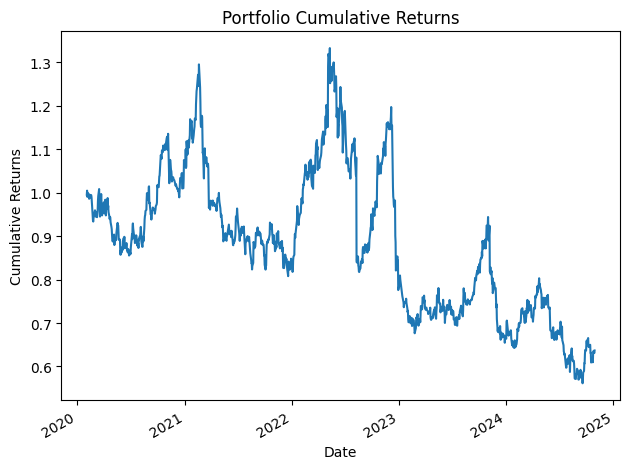

INFO:__main__:Plotted portfolio performance.
INFO:__main__:Workflow completed for all tickers.


In [ ]:
def main():
    # Define directories and files
    feature_files_dir = "/content"        # Directory containing {ticker}_technical_top_features.csv
    signals_output_dir = "/signals"        # Directory to save generated signals
    cumulative_returns_output = "portfolio_cumulative_returns.csv"  # Output file for portfolio returns



    # Generate signals and backtest
    generate_signals_and_backtest(feature_files_dir, summary_dict, signals_output_dir, cumulative_returns_output)

    logger.info("Workflow completed for all tickers.")

if __name__ == "__main__":
    main()


Processed BABA:
                       Datetime  Close  Signal   Returns
1190  2024-10-23 00:00:00+00:00  98.00       1 -0.024487
1191  2024-10-24 00:00:00+00:00  96.36       1 -0.016735
1192  2024-10-25 00:00:00+00:00  97.42       1  0.011000
1193  2024-10-28 00:00:00+00:00  99.93       1  0.025765
1194  2024-10-29 00:00:00+00:00  99.83       1 -0.001001
Saved signals for BABA to /content/BABA_signals.csv
Processed JD:
                       Datetime  Close  Signal   Returns
1190  2024-10-23 00:00:00+00:00  40.00       1 -0.008674
1191  2024-10-24 00:00:00+00:00  39.33       1 -0.016750
1192  2024-10-25 00:00:00+00:00  39.90       1  0.014493
1193  2024-10-28 00:00:00+00:00  41.64       1  0.043609
1194  2024-10-29 00:00:00+00:00  41.14       1 -0.012008
Saved signals for JD to /content/JD_signals.csv
Processed FOUR:
                       Datetime  Close  Signal   Returns
1043  2024-10-23 00:00:00+00:00  93.25       1  0.003335
1044  2024-10-24 00:00:00+00:00  93.74       1  0.005255

<Axes: title={'center': 'Portfolio Performance'}>

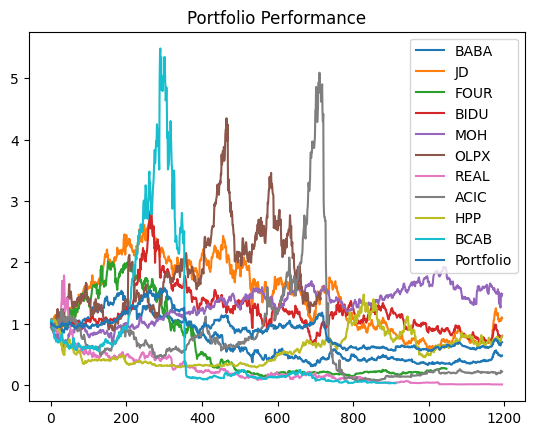

In [ ]:
def generate_signals_and_backtest(df, top_features):
    """
    Generate trading signals and backtest.
    """
    # Generate composite signals based on top features
    composite_signal = df[top_features].mean(axis=1)  # Example composite signal
    df['Signal'] = 0
    df.loc[composite_signal > 0.5, 'Signal'] = 1  # Buy signal
    df.loc[composite_signal < -0.5, 'Signal'] = -1  # Sell signal

    # Backtest (example: calculate portfolio returns)
    df['Returns'] = df['Close'].pct_change() * df['Signal'].shift()
    cumulative_returns = (1 + df['Returns']).cumprod()

    return cumulative_returns, df


# Process each ticker
for ticker in tickers:
    features_file = os.path.join(feature_files_dir, f"{ticker}_technical_top_features.csv")
    if not os.path.exists(features_file):
        print(f"File not found for {ticker}. Skipping...")
        continue

    # Load precomputed data
    df = pd.read_csv(features_file)

    # Get top features from summary_dict
    top_features = summary_dict.get(ticker, [])
    if not top_features:
        print(f"No top features available for {ticker}. Skipping...")
        continue

    # Generate signals and backtest
    cumulative_returns, processed_df = generate_signals_and_backtest(df, top_features)
    print(f"Processed {ticker}:")
    print(processed_df[['Datetime', 'Close', 'Signal', 'Returns']].tail())

    # Save processed signals to file
    output_file = os.path.join(feature_files_dir, f"{ticker}_signals.csv")
    processed_df.to_csv(output_file, index=False)
    print(f"Saved signals for {ticker} to {output_file}")
# Combine cumulative returns for all tickers
portfolio_cumulative_returns = pd.DataFrame()

for ticker in tickers:
    signals_file = os.path.join(feature_files_dir, f"{ticker}_signals.csv")
    if not os.path.exists(signals_file):
        print(f"Signals file missing for {ticker}. Generating...")
        # Generate signals
        df = pd.read_csv(os.path.join(feature_files_dir, f"{ticker}_technical_top_features.csv"))
        top_features = summary_dict.get(ticker, [])
        if not top_features:
            print(f"No top features available for {ticker}. Skipping...")
            continue
        cumulative_returns, processed_df = generate_signals_and_backtest(df, top_features)
        processed_df.to_csv(signals_file, index=False)
        print(f"Saved signals for {ticker} to {signals_file}")
    df = pd.read_csv(signals_file)
    portfolio_cumulative_returns[ticker] = (1 + df['Returns']).cumprod()
if portfolio_cumulative_returns.empty:
    print("No cumulative returns available for the portfolio. Exiting...")
    exit()

# Calculate portfolio metrics
portfolio_cumulative_returns['Portfolio'] = portfolio_cumulative_returns.mean(axis=1)
sharpe_ratio = portfolio_cumulative_returns['Portfolio'].pct_change().mean() / portfolio_cumulative_returns['Portfolio'].pct_change().std() * (252**0.5)
max_drawdown = (portfolio_cumulative_returns['Portfolio'] / portfolio_cumulative_returns['Portfolio'].cummax() - 1).min()

print(f"Portfolio Sharpe Ratio: {sharpe_ratio}")
print(f"Portfolio Max Drawdown: {max_drawdown}")

# Plot portfolio performance
portfolio_cumulative_returns.plot(title="Portfolio Performance")


#Experiments


[*********************100%***********************]  1 of 1 completed

Loaded price data.
Loaded trading signals.
Tickers extracted from signals: ['HPP', 'BCAB', 'JD', 'OLPX', 'BIDU', 'REAL', 'MOH', 'ACIC', 'BABA', 'FOUR']
Fetched benchmark data for ^GSPC.
Aligned and cleaned data.
End of 2020-01-31: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-03: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-04: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-05: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-06: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-07: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-10: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}


<ipython-input-52-a28ac314d393>:451: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.reindex(signals_df.index).fillna(method='ffill')
<ipython-input-52-a28ac314d393>:452: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_data = benchmark_data.reindex(signals_df.index).fillna(method='ffill')



End of 2020-02-11: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-12: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
Shorted 6 shares of MOH at 145.58 on 2020-02-13, proceeds: 872.61
Shorted 25 shares of JD at 39.24 on 2020-02-13, proceeds: 980.12
Shorted 103 shares of ACIC at 9.64 on 2020-02-13, proceeds: 992.12
Shorted 64 shares of REAL at 15.43 on 2020-02-13, proceeds: 986.53
Shorted 7 shares of BIDU at 135.18 on 2020-02-13, proceeds: 945.31
Shorted 4 shares of BABA at 212.81 on 2020-02-13, proceeds: 850.40
Shorted 32 shares of HPP at 30.39 on 2020-02-13, proceeds: 971.52
End of 2020-02-13: Cash: 16598.60, Portfolio Value: 9993.39, Holdings: {}, Short Holdings: {'MOH': 6, 'JD': 25, 'ACIC': 103, 'REAL': 64, 'BIDU': 7, 'BABA': 4, 'HPP': 32}
Trailing Stop-Loss Triggered at 30.69 with Current Price = 30.80
Trailing Stop for HPP: Covered 32 shares at 30.80 on 2020-02-14, cost: 986.46
End of 2020-02-14: Cash: 15612.

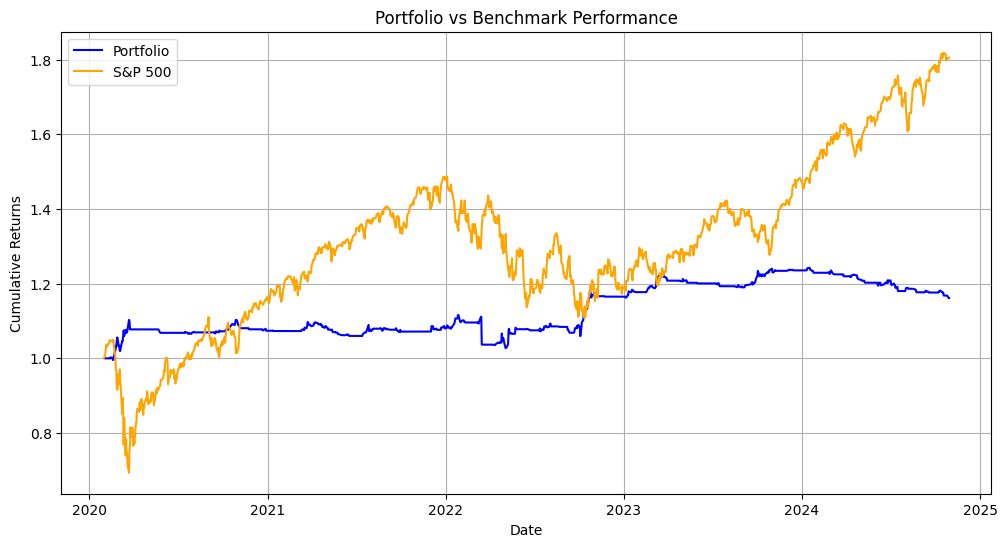

In [ ]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Fetch historical price data from yfinance for benchmark
def fetch_benchmark_data(ticker, start_date, end_date):
    """
    Fetch historical benchmark data using yfinance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    if 'Adj Close' in data.columns:
        benchmark = data['Adj Close']
    else:
        benchmark = data['Close']
    benchmark.name = ticker
    return benchmark

# Load price data from CSV
def load_price_data(price_data_file):
    """
    Load historical price data from a CSV file.
    """
    if not os.path.exists(price_data_file):
        raise FileNotFoundError(f"Price data file '{price_data_file}' not found.")

    price_data = pd.read_csv(price_data_file, index_col='Datetime', parse_dates=True)
    price_data.sort_index(inplace=True)
    return price_data

# Dynamic position sizing based on volatility
def calculate_position_size(portfolio_value, price, volatility, target_risk=0.05):
    """
    Calculate the number of shares to buy based on target risk and volatility.
    """
    if volatility <= 0 or np.isnan(volatility):
        volatility = 0.02  # Default volatility to prevent division by zero

    target_allocation = target_risk / volatility
    allocation = portfolio_value * target_allocation
    shares_to_buy = int(allocation // price)

    return shares_to_buy

# Apply risk controls
def apply_risk_controls(price, entry_price, stop_loss=0.03, take_profit=0.06,
                        trailing_stop=None, max_price=None, volatility=None, position_type='long'):
    """
    Apply risk control mechanisms to determine if a position should be sold.
    """
    # Adjust stop-loss and take-profit based on volatility
    if volatility is not None:
        stop_loss *= (1 + volatility)
        take_profit *= (1 + volatility)

    # Trailing stop-loss logic
    if trailing_stop is not None and max_price is not None:
        if position_type == 'long':
            trailing_stop_price = max_price * (1 - trailing_stop)
            if price <= trailing_stop_price:
                print(f"Trailing Stop-Loss Triggered at {trailing_stop_price:.2f} with Current Price = {price:.2f}")
                return 'Trailing Stop'
        elif position_type == 'short':
            trailing_stop_price = max_price * (1 + trailing_stop)
            if price >= trailing_stop_price:
                print(f"Trailing Stop-Loss Triggered at {trailing_stop_price:.2f} with Current Price = {price:.2f}")
                return 'Trailing Stop'

    # Standard stop-loss and take-profit
    if position_type == 'long':
        if price <= entry_price * (1 - stop_loss):
            print(f"Stop-Loss Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Stop'  # Trigger a stop-loss
        elif price >= entry_price * (1 + take_profit):
            print(f"Take-Profit Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Take Profit'  # Trigger a take-profit
    elif position_type == 'short':
        if price >= entry_price * (1 + stop_loss):
            print(f"Stop-Loss Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Stop'  # Trigger a stop-loss
        elif price <= entry_price * (1 - take_profit):
            print(f"Take-Profit Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Take Profit'  # Trigger a take-profit

    return 'Hold'

# Mean-Variance Optimization for portfolio rebalancing
def mean_variance_optimization(expected_returns, cov_matrix, risk_free_rate=0.0, leverage=3):
    """
    Perform mean-variance optimization to determine optimal portfolio weights.

    Parameters:
    - expected_returns (np.array): Expected returns for each asset.
    - cov_matrix (np.array): Covariance matrix of asset returns.
    - risk_free_rate (float): Risk-free rate for Sharpe ratio.
    - leverage (float): Maximum allowed leverage.

    Returns:
    - np.array: Optimal weights for each asset.
    """
    n = len(expected_returns)
    weights = cp.Variable(n)

    portfolio_return = expected_returns @ weights
    portfolio_risk = cp.quad_form(weights, cov_matrix)

    objective = cp.Maximize(portfolio_return - 0.5 * portfolio_risk)
    constraints = [
        cp.sum(weights) == 1,
        cp.norm(weights, 1) <= leverage  # Leverage constraint
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return weights.value

# Construct portfolio based on signals and apply risk controls
def construct_portfolio(price_data, signals_df, initial_investment=10000, transaction_cost=0.01,
                        target_risk=0.05, use_risk_controls=True, trailing_stop=None,
                        volatility_adjusted=True, time_exit_days=None):
    """
    Construct and manage a portfolio based on trading signals and risk controls.
    """
    cash = initial_investment
    portfolio = {}  # Long Holdings: {ticker: shares}
    short_portfolio = {}  # Short Holdings: {ticker: shares}
    entry_prices = {}  # Entry price for long positions
    short_entry_prices = {}  # Entry price for short positions
    max_prices = {}  # Max price for trailing stop
    entry_dates = {}  # Entry dates for time-based exits (long)
    short_entry_dates = {}  # Entry dates for time-based exits (short)
    sell_signal_counts = {}  # Track consecutive sell signals
    daily_portfolio_value = []
    status = {}  # Status per asset: 'Bought', 'Sold', 'Shorted', 'Covered'

    # Precompute volatility data if needed
    if volatility_adjusted:
        volatility_data = price_data.pct_change().rolling(window=20).std()
    else:
        volatility_data = pd.DataFrame(0.02, index=price_data.index, columns=price_data.columns)

    # Calculate expected returns and covariance matrix for MVO
    expected_returns = price_data.pct_change().mean().values
    cov_matrix = price_data.pct_change().cov().values

    for date, row in signals_df.iterrows():
        if date not in price_data.index:
            continue  # Skip dates not in price data

        # Define tickers to buy, sell, hold
        buy_tickers = row['Tickers to buy'].split(', ') if isinstance(row['Tickers to buy'], str) else []
        sell_tickers = row['Tickers to sell'].split(', ') if isinstance(row['Tickers to sell'], str) else []
        hold_tickers = row['Tickers to hold'].split(', ') if isinstance(row['Tickers to hold'], str) else []
        # Short tickers will be determined based on consecutive sell signals

        # Update sell signal counts
        for ticker in price_data.columns:
            if ticker in sell_tickers:
                sell_signal_counts[ticker] = sell_signal_counts.get(ticker, 0) + 1
            else:
                sell_signal_counts[ticker] = 0

        # Check for short initiation (10 consecutive sell signals)
        short_threshold = 10
        for ticker, count in sell_signal_counts.items():
            if count >= short_threshold and ticker not in short_portfolio and ticker not in portfolio:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    # Calculate volatility and shares to short based on target allocation
                    volatility = volatility_data.loc[date, ticker] if volatility_adjusted else 0.02
                    max_short_allocation = 0.1  # 10% of portfolio
                    short_allocation = initial_investment * max_short_allocation
                    shares_to_short = int(short_allocation // price)
                    if shares_to_short > 0:
                        short_portfolio[ticker] = shares_to_short
                        short_entry_prices[ticker] = price  # Record entry price for short
                        short_entry_dates[ticker] = date  # Track entry date for time-based exit
                        max_prices[ticker] = price  # Set initial max price for trailing stop
                        proceeds = price * shares_to_short * (1 - transaction_cost)
                        cash += proceeds
                        status[ticker] = 'Shorted'
                        print(f"Shorted {shares_to_short} shares of {ticker} at {price:.2f} on {date.date()}, proceeds: {proceeds:.2f}")

        # Calculate current portfolio value
        portfolio_value = cash + sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        ) - sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in short_portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        )

        # Rebalance portfolio using Mean-Variance Optimization every rebalance period or certain condition
        # Here, assuming rebalancing is done daily
        current_holdings = list(portfolio.keys()) + list(short_portfolio.keys())
        if current_holdings:
            indices = [price_data.columns.get_loc(ticker) for ticker in current_holdings]
            expected_ret = expected_returns[indices]
            cov = cov_matrix[np.ix_(indices, indices)]
            weights = mean_variance_optimization(expected_ret, cov, leverage=3)
            # Normalize weights
            weights /= np.sum(np.abs(weights))

            # Adjust weights to current holdings
            for i, ticker in enumerate(current_holdings):
                target_weight = weights[i]
                if ticker in portfolio:
                    current_shares = portfolio[ticker]
                    target_shares = int((target_weight * portfolio_value) // price_data.loc[date, ticker])
                    if target_shares > current_shares:
                        # Buy additional shares
                        additional_shares = target_shares - current_shares
                        cost = price_data.loc[date, ticker] * additional_shares * (1 + transaction_cost)
                        if cash >= cost:
                            portfolio[ticker] += additional_shares
                            cash -= cost
                            entry_prices[ticker] = price_data.loc[date, ticker]
                            print(f"Rebalanced: Bought additional {additional_shares} shares of {ticker} at {price_data.loc[date, ticker]:.2f} on {date.date()}, cost: {cost:.2f}")
                    elif target_shares < current_shares:
                        # Sell excess shares
                        excess_shares = current_shares - target_shares
                        income = price_data.loc[date, ticker] * excess_shares * (1 - transaction_cost)
                        portfolio[ticker] -= excess_shares
                        cash += income
                        print(f"Rebalanced: Sold {excess_shares} shares of {ticker} at {price_data.loc[date, ticker]:.2f} on {date.date()}, income: {income:.2f}")
                        if portfolio[ticker] == 0:
                            del portfolio[ticker]
                            del entry_prices[ticker]

        # Buying logic with position sizing and status check
        for ticker in buy_tickers:
            if status.get(ticker, 'Sold') == 'Sold' and ticker not in short_portfolio and ticker in price_data.columns:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    # Calculate volatility and shares to buy based on target allocation
                    volatility = volatility_data.loc[date, ticker] if volatility_adjusted else 0.02
                    shares_to_buy = calculate_position_size(portfolio_value, price, volatility, target_risk=target_risk)
                    cost = price * shares_to_buy * (1 + transaction_cost)

                    if shares_to_buy > 0 and cash >= cost:
                        portfolio[ticker] = portfolio.get(ticker, 0) + shares_to_buy
                        entry_prices[ticker] = price  # Record entry price
                        max_prices[ticker] = price  # Set initial max price for trailing stop
                        entry_dates[ticker] = date  # Track entry date for time-based exit
                        cash -= cost
                        status[ticker] = 'Bought'
                        print(f"Bought {shares_to_buy} shares of {ticker} at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Selling logic based on explicit sell signals
        for ticker in sell_tickers:
            if ticker in portfolio:
                price = price_data.loc[date, ticker]
                shares_to_sell = portfolio[ticker]
                income = shares_to_sell * price * (1 - transaction_cost)
                cash += income
                del portfolio[ticker]
                del entry_prices[ticker]
                del max_prices[ticker]
                del entry_dates[ticker]
                status[ticker] = 'Sold'
                print(f"Sold {shares_to_sell} shares of {ticker} at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Apply risk controls on existing long positions
        for ticker in list(portfolio.keys()):
            price = price_data.loc[date, ticker]
            if not np.isnan(price) and ticker in entry_prices and use_risk_controls:
                # Update max price for trailing stop
                if trailing_stop is not None:
                    if price > max_prices.get(ticker, price):
                        max_prices[ticker] = price

                # Get volatility value
                volatility_value = volatility_data.loc[date, ticker] if volatility_adjusted else None

                # Apply risk controls
                risk_control_action = apply_risk_controls(
                    price,
                    entry_prices[ticker],
                    stop_loss=0.06,
                    take_profit=0.06,
                    trailing_stop=trailing_stop,
                    max_price=max_prices.get(ticker),
                    volatility=volatility_value,
                    position_type='long'
                )

                if risk_control_action in ['Stop', 'Take Profit', 'Trailing Stop']:
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]  # Remove from holdings
                    del entry_prices[ticker]
                    del max_prices[ticker]
                    del entry_dates[ticker]
                    status[ticker] = 'Sold'
                    print(f"{risk_control_action} for {ticker}: Sold {shares_to_sell} shares at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Apply risk controls on existing short positions
        for ticker in list(short_portfolio.keys()):
            price = price_data.loc[date, ticker]
            if not np.isnan(price) and ticker in short_entry_prices and use_risk_controls:
                # Update max price for trailing stop
                if trailing_stop is not None:
                    if price < max_prices.get(ticker, price):
                        max_prices[ticker] = price

                # Get volatility value
                volatility_value = volatility_data.loc[date, ticker] if volatility_adjusted else None

                # Apply risk controls
                risk_control_action = apply_risk_controls(
                    price,
                    short_entry_prices[ticker],
                    stop_loss=0.06,
                    take_profit=0.06,
                    trailing_stop=trailing_stop,
                    max_price=max_prices.get(ticker),
                    volatility=volatility_value,
                    position_type='short'
                )

                if risk_control_action in ['Stop', 'Take Profit', 'Trailing Stop']:
                    shares_to_cover = short_portfolio[ticker]
                    cost = shares_to_cover * price * (1 + transaction_cost)
                    cash -= cost
                    del short_portfolio[ticker]
                    del short_entry_prices[ticker]
                    del max_prices[ticker]
                    del short_entry_dates[ticker]
                    status[ticker] = 'Covered'
                    print(f"{risk_control_action} for {ticker}: Covered {shares_to_cover} shares at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Time-based exit logic for long positions
        for ticker in list(portfolio.keys()):
            if time_exit_days and (date - entry_dates[ticker]).days >= time_exit_days:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]
                    del entry_prices[ticker]
                    del max_prices[ticker]
                    del entry_dates[ticker]
                    status[ticker] = 'Sold'
                    print(f"Time-Based Exit for {ticker}: Sold {shares_to_sell} shares at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Time-based exit logic for short positions
        for ticker in list(short_portfolio.keys()):
            if time_exit_days and (date - short_entry_dates[ticker]).days >= time_exit_days:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    shares_to_cover = short_portfolio[ticker]
                    cost = shares_to_cover * price * (1 + transaction_cost)
                    cash -= cost
                    del short_portfolio[ticker]
                    del short_entry_prices[ticker]
                    del max_prices[ticker]
                    del short_entry_dates[ticker]
                    status[ticker] = 'Covered'
                    print(f"Time-Based Exit for {ticker}: Covered {shares_to_cover} shares at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Track portfolio value for the day
        current_value = cash + sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        ) - sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in short_portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        )
        daily_portfolio_value.append(current_value)
        print(f"End of {date.date()}: Cash: {cash:.2f}, Portfolio Value: {current_value:.2f}, Holdings: {portfolio}, Short Holdings: {short_portfolio}")

    # Convert daily portfolio values to a Series for easy analysis
    portfolio_values = pd.Series(daily_portfolio_value, index=signals_df.index)
    return portfolio_values

# Backtest performance evaluation
def calculate_performance(portfolio_values):
    """
    Calculate cumulative returns, Sharpe Ratio, and Max Drawdown.
    """
    returns = portfolio_values.pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return cumulative_returns, sharpe_ratio, max_drawdown

# Visualization of portfolio vs benchmark performance
def plot_performance(cumulative_returns, benchmark_returns, benchmark_name='Benchmark'):
    """
    Plot the cumulative returns of the portfolio and benchmark.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Portfolio', color='blue')
    plt.plot(benchmark_returns, label=benchmark_name, color='orange')
    plt.title('Portfolio vs Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main script
if __name__ == "__main__":
    # Define file paths
    price_data_file = "price_data.csv"  # Ensure this file exists in the working directory
    signals_file = "daily_buy_sell_hold_signals.csv"  # Ensure this file exists and is correctly formatted

    # Check if required files exist
    if not os.path.exists(price_data_file):
        print(f"Error: '{price_data_file}' not found.")
        exit()
    if not os.path.exists(signals_file):
        print(f"Error: '{signals_file}' not found.")
        exit()

    # Load price data
    price_data = load_price_data(price_data_file)
    print("Loaded price data.")

    # Load signals data
    signals_df = pd.read_csv(signals_file)
    signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])
    signals_df.set_index('Datetime', inplace=True)
    print("Loaded trading signals.")

    # Define date range and extract tickers from signals
    start_date, end_date = signals_df.index.min(), signals_df.index.max()
    tickers = list(set(
        ticker
        for col in ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']
        for tickers_list in signals_df[col].fillna('').apply(lambda x: x.split(', ') if x else [])
        for ticker in tickers_list
    ))
    print(f"Tickers extracted from signals: {tickers}")

    # Fetch benchmark data (e.g., S&P 500)
    benchmark_ticker = '^GSPC'  # S&P 500
    benchmark_data = fetch_benchmark_data(benchmark_ticker, start_date, end_date)
    print(f"Fetched benchmark data for {benchmark_ticker}.")

    # Align and clean data
    price_data = price_data.reindex(signals_df.index).fillna(method='ffill')
    benchmark_data = benchmark_data.reindex(signals_df.index).fillna(method='ffill')
    signals_df = signals_df[signals_df.index.isin(price_data.index)]
    print("Aligned and cleaned data.")

    # Construct portfolio and calculate returns
    portfolio_values = construct_portfolio(
        price_data=price_data,
        signals_df=signals_df,
        initial_investment=10000,
        transaction_cost=0.001,
        target_risk=0.05,
        use_risk_controls=True,
        trailing_stop=0.01,  # 1% trailing stop-loss
        volatility_adjusted=True,
        time_exit_days=15  # Exit positions after 15 days
    )
    print("Constructed portfolio and calculated daily values.")

    # Benchmark cumulative returns
    benchmark_returns = (1 + benchmark_data.pct_change().fillna(0)).cumprod()

    # Performance evaluation
    cumulative_returns, sharpe_ratio, max_drawdown = calculate_performance(portfolio_values)
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot performance
    plot_performance(cumulative_returns, benchmark_returns, benchmark_name='S&P 500')


[*********************100%***********************]  1 of 1 completed

Loaded price data.
Loaded trading signals.
Tickers extracted from signals: ['HPP', 'BCAB', 'JD', 'OLPX', 'BIDU', 'REAL', 'MOH', 'ACIC', 'BABA', 'FOUR']
Fetched benchmark data for ^GSPC.
Aligned and cleaned data.
End of 2020-01-31: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-03: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-04: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-05: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-06: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-07: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-10: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-11: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}, Short Holdings: {}
End of 2020-02-12: Cash: 100


<ipython-input-55-a8357296141c>:378: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.reindex(signals_df.index).fillna(method='ffill')
<ipython-input-55-a8357296141c>:379: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_data = benchmark_data.reindex(signals_df.index).fillna(method='ffill')


Shorted 66 shares of REAL at 14.95 on 2020-02-24, proceeds: 985.71
Trailing Stop-Loss Triggered at 9.17 with Current Price = 9.20
Trailing Stop for ACIC: Covered 103 shares at 9.20 on 2020-02-24, cost: 948.37
End of 2020-02-24: Cash: 15563.11, Portfolio Value: 10213.16, Holdings: {}, Short Holdings: {'HPP': 32, 'MOH': 6, 'JD': 25, 'BIDU': 7, 'BABA': 4, 'REAL': 66}
Shorted 108 shares of ACIC at 9.24 on 2020-02-25, proceeds: 997.30
End of 2020-02-25: Cash: 16560.41, Portfolio Value: 10321.99, Holdings: {}, Short Holdings: {'HPP': 32, 'MOH': 6, 'JD': 25, 'BIDU': 7, 'BABA': 4, 'REAL': 66, 'ACIC': 108}
Trailing Stop-Loss Triggered at 36.65 with Current Price = 37.29
Trailing Stop for JD: Covered 25 shares at 37.29 on 2020-02-26, cost: 933.22
Trailing Stop-Loss Triggered at 200.55 with Current Price = 201.59
Trailing Stop for BABA: Covered 4 shares at 201.59 on 2020-02-26, cost: 807.17
End of 2020-02-26: Cash: 14820.03, Portfolio Value: 10321.84, Holdings: {}, Short Holdings: {'HPP': 32, 'MO

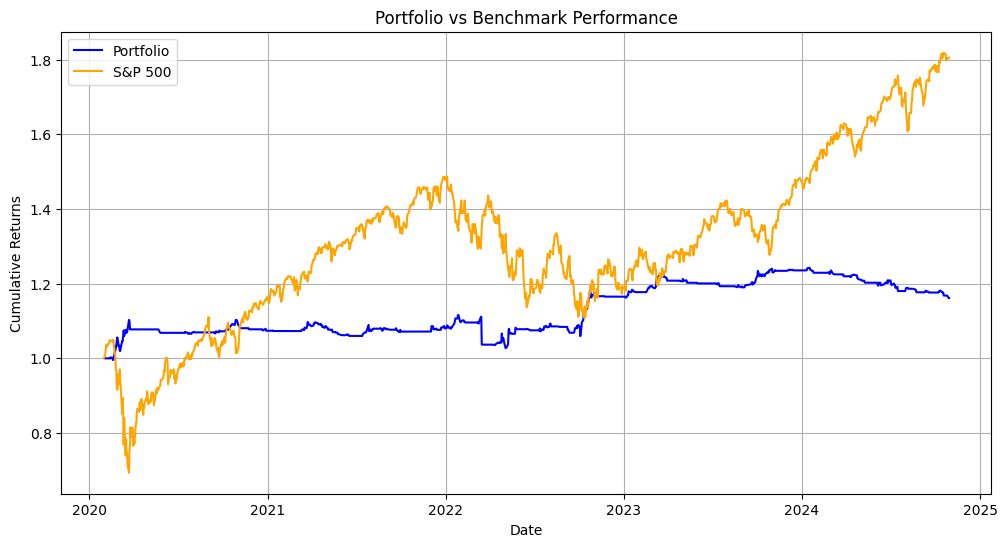

In [ ]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical price data from yfinance for benchmark
def fetch_benchmark_data(ticker, start_date, end_date):
    """
    Fetch historical benchmark data using yfinance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    if 'Adj Close' in data.columns:
        benchmark = data['Adj Close']
    else:
        benchmark = data['Close']
    benchmark.name = ticker
    return benchmark

# Load price data from CSV
def load_price_data(price_data_file):
    """
    Load historical price data from a CSV file.
    """
    if not os.path.exists(price_data_file):
        raise FileNotFoundError(f"Price data file '{price_data_file}' not found.")

    price_data = pd.read_csv(price_data_file, index_col='Datetime', parse_dates=True)
    price_data.sort_index(inplace=True)
    return price_data

# Dynamic position sizing based on volatility
def calculate_position_size(portfolio_value, price, volatility, target_risk=0.05):
    """
    Calculate the number of shares to buy based on target risk and volatility.
    """
    if volatility <= 0 or np.isnan(volatility):
        volatility = 0.02  # Default volatility to prevent division by zero

    target_allocation = target_risk / volatility
    allocation = portfolio_value * target_allocation
    shares_to_buy = int(allocation // price)

    return shares_to_buy

# Apply risk controls
def apply_risk_controls(price, entry_price, stop_loss=0.03, take_profit=0.06,
                        trailing_stop=None, max_price=None, volatility=None, position_type='long'):
    """
    Apply risk control mechanisms to determine if a position should be sold.
    """
    # Adjust stop-loss and take-profit based on volatility
    if volatility is not None:
        stop_loss *= (1 + volatility)
        take_profit *= (1 + volatility)

    # Trailing stop-loss logic
    if trailing_stop is not None and max_price is not None:
        if position_type == 'long':
            trailing_stop_price = max_price * (1 - trailing_stop)
            if price <= trailing_stop_price:
                print(f"Trailing Stop-Loss Triggered at {trailing_stop_price:.2f} with Current Price = {price:.2f}")
                return 'Trailing Stop'
        elif position_type == 'short':
            trailing_stop_price = max_price * (1 + trailing_stop)
            if price >= trailing_stop_price:
                print(f"Trailing Stop-Loss Triggered at {trailing_stop_price:.2f} with Current Price = {price:.2f}")
                return 'Trailing Stop'

    # Standard stop-loss and take-profit
    if position_type == 'long':
        if price <= entry_price * (1 - stop_loss):
            print(f"Stop-Loss Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Stop'  # Trigger a stop-loss
        elif price >= entry_price * (1 + take_profit):
            print(f"Take-Profit Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Take Profit'  # Trigger a take-profit
    elif position_type == 'short':
        if price >= entry_price * (1 + stop_loss):
            print(f"Stop-Loss Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Stop'  # Trigger a stop-loss
        elif price <= entry_price * (1 - take_profit):
            print(f"Take-Profit Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
            return 'Take Profit'  # Trigger a take-profit

    return 'Hold'

# Construct portfolio based on signals and apply risk controls
def construct_portfolio(price_data, signals_df, initial_investment=10000, transaction_cost=0.01,
                        target_risk=0.05, use_risk_controls=True, trailing_stop=None,
                        volatility_adjusted=True, time_exit_days=None):
    """
    Construct and manage a portfolio based on trading signals and risk controls.
    """
    cash = initial_investment
    portfolio = {}  # Long Holdings: {ticker: shares}
    short_portfolio = {}  # Short Holdings: {ticker: shares}
    entry_prices = {}  # Entry price for long positions
    short_entry_prices = {}  # Entry price for short positions
    max_prices = {}  # Max price for trailing stop
    entry_dates = {}  # Entry dates for time-based exits (long)
    short_entry_dates = {}  # Entry dates for time-based exits (short)
    sell_signal_counts = {}  # Track consecutive sell signals
    daily_portfolio_value = []
    status = {}  # Status per asset: 'Bought', 'Sold', 'Shorted', 'Covered'

    # Precompute volatility data if needed
    if volatility_adjusted:
        volatility_data = price_data.pct_change().rolling(window=20).std()
    else:
        volatility_data = pd.DataFrame(0.02, index=price_data.index, columns=price_data.columns)

    for date, row in signals_df.iterrows():
        if date not in price_data.index:
            continue  # Skip dates not in price data

        # Define tickers to buy, sell, hold
        buy_tickers = row['Tickers to buy'].split(', ') if isinstance(row['Tickers to buy'], str) else []
        sell_tickers = row['Tickers to sell'].split(', ') if isinstance(row['Tickers to sell'], str) else []
        hold_tickers = row['Tickers to hold'].split(', ') if isinstance(row['Tickers to hold'], str) else []
        # Short tickers will be determined based on consecutive sell signals

        # Update sell signal counts
        for ticker in price_data.columns:
            if ticker in sell_tickers:
                sell_signal_counts[ticker] = sell_signal_counts.get(ticker, 0) + 1
            else:
                sell_signal_counts[ticker] = 0

        # Check for short initiation (10 consecutive sell signals)
        short_threshold = 10
        for ticker, count in sell_signal_counts.items():
            if count >= short_threshold and ticker not in short_portfolio and ticker not in portfolio:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    # Calculate volatility and shares to short based on target allocation
                    volatility = volatility_data.loc[date, ticker] if volatility_adjusted else 0.02
                    max_short_allocation = 0.1  # 10% of portfolio
                    short_allocation = initial_investment * max_short_allocation
                    shares_to_short = int(short_allocation // price)
                    if shares_to_short > 0:
                        short_portfolio[ticker] = shares_to_short
                        short_entry_prices[ticker] = price  # Record entry price for short
                        short_entry_dates[ticker] = date  # Track entry date for time-based exit
                        max_prices[ticker] = price  # Set initial max price for trailing stop
                        proceeds = price * shares_to_short * (1 - transaction_cost)
                        cash += proceeds
                        status[ticker] = 'Shorted'
                        print(f"Shorted {shares_to_short} shares of {ticker} at {price:.2f} on {date.date()}, proceeds: {proceeds:.2f}")

        # Calculate current portfolio value
        portfolio_value = cash + sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        ) - sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in short_portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        )

        # Buying logic with position sizing and status check
        for ticker in buy_tickers:
            if status.get(ticker, 'Sold') == 'Sold' and ticker in price_data.columns:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    # Calculate volatility and shares to buy based on target allocation
                    volatility = volatility_data.loc[date, ticker] if volatility_adjusted else 0.02
                    shares_to_buy = calculate_position_size(portfolio_value, price, volatility, target_risk=target_risk)
                    cost = price * shares_to_buy * (1 + transaction_cost)

                    if shares_to_buy > 0 and cash >= cost:
                        portfolio[ticker] = portfolio.get(ticker, 0) + shares_to_buy
                        entry_prices[ticker] = price  # Record entry price
                        max_prices[ticker] = price  # Set initial max price for trailing stop
                        entry_dates[ticker] = date  # Track entry date for time-based exit
                        cash -= cost
                        status[ticker] = 'Bought'
                        print(f"Bought {shares_to_buy} shares of {ticker} at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Selling logic based on explicit sell signals
        for ticker in sell_tickers:
            if ticker in portfolio:
                price = price_data.loc[date, ticker]
                shares_to_sell = portfolio[ticker]
                income = shares_to_sell * price * (1 - transaction_cost)
                cash += income
                del portfolio[ticker]
                del entry_prices[ticker]
                del max_prices[ticker]
                del entry_dates[ticker]
                status[ticker] = 'Sold'
                print(f"Sold {shares_to_sell} shares of {ticker} at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Apply risk controls on existing long positions
        for ticker in list(portfolio.keys()):
            price = price_data.loc[date, ticker]
            if not np.isnan(price) and ticker in entry_prices and use_risk_controls:
                # Update max price for trailing stop
                if trailing_stop is not None:
                    if price > max_prices.get(ticker, price):
                        max_prices[ticker] = price

                # Get volatility value
                volatility_value = volatility_data.loc[date, ticker] if volatility_adjusted else None

                # Apply risk controls
                risk_control_action = apply_risk_controls(
                    price,
                    entry_prices[ticker],
                    stop_loss=0.03,
                    take_profit=0.06,
                    trailing_stop=trailing_stop,
                    max_price=max_prices.get(ticker),
                    volatility=volatility_value,
                    position_type='long'
                )

                if risk_control_action in ['Stop', 'Take Profit', 'Trailing Stop']:
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]  # Remove from holdings
                    del entry_prices[ticker]
                    del max_prices[ticker]
                    del entry_dates[ticker]
                    status[ticker] = 'Sold'
                    print(f"{risk_control_action} for {ticker}: Sold {shares_to_sell} shares at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Apply risk controls on existing short positions
        for ticker in list(short_portfolio.keys()):
            price = price_data.loc[date, ticker]
            if not np.isnan(price) and ticker in short_entry_prices and use_risk_controls:
                # Update max price for trailing stop
                if trailing_stop is not None:
                    if price < max_prices.get(ticker, price):
                        max_prices[ticker] = price

                # Get volatility value
                volatility_value = volatility_data.loc[date, ticker] if volatility_adjusted else None

                # Apply risk controls
                risk_control_action = apply_risk_controls(
                    price,
                    short_entry_prices[ticker],
                    stop_loss=0.03,
                    take_profit=0.06,
                    trailing_stop=trailing_stop,
                    max_price=max_prices.get(ticker),
                    volatility=volatility_value,
                    position_type='short'
                )

                if risk_control_action in ['Stop', 'Take Profit', 'Trailing Stop']:
                    shares_to_cover = short_portfolio[ticker]
                    cost = shares_to_cover * price * (1 + transaction_cost)
                    cash -= cost
                    del short_portfolio[ticker]
                    del short_entry_prices[ticker]
                    del max_prices[ticker]
                    del short_entry_dates[ticker]
                    status[ticker] = 'Covered'
                    print(f"{risk_control_action} for {ticker}: Covered {shares_to_cover} shares at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Time-based exit logic for long positions
        for ticker in list(portfolio.keys()):
            if time_exit_days and (date - entry_dates[ticker]).days >= time_exit_days:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]
                    del entry_prices[ticker]
                    del max_prices[ticker]
                    del entry_dates[ticker]
                    status[ticker] = 'Sold'
                    print(f"Time-Based Exit for {ticker}: Sold {shares_to_sell} shares at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Time-based exit logic for short positions
        for ticker in list(short_portfolio.keys()):
            if time_exit_days and (date - short_entry_dates[ticker]).days >= time_exit_days:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    shares_to_cover = short_portfolio[ticker]
                    cost = shares_to_cover * price * (1 + transaction_cost)
                    cash -= cost
                    del short_portfolio[ticker]
                    del short_entry_prices[ticker]
                    del max_prices[ticker]
                    del short_entry_dates[ticker]
                    status[ticker] = 'Covered'
                    print(f"Time-Based Exit for {ticker}: Covered {shares_to_cover} shares at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Track portfolio value for the day
        current_value = cash + sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        ) - sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in short_portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        )
        daily_portfolio_value.append(current_value)
        print(f"End of {date.date()}: Cash: {cash:.2f}, Portfolio Value: {current_value:.2f}, Holdings: {portfolio}, Short Holdings: {short_portfolio}")

    # Convert daily portfolio values to a Series for easy analysis
    portfolio_values = pd.Series(daily_portfolio_value, index=signals_df.index)
    return portfolio_values

# Backtest performance evaluation
def calculate_performance(portfolio_values):
    """
    Calculate cumulative returns, Sharpe Ratio, and Max Drawdown.
    """
    returns = portfolio_values.pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return cumulative_returns, sharpe_ratio, max_drawdown

# Visualization of portfolio vs benchmark performance
def plot_performance(cumulative_returns, benchmark_returns, benchmark_name='Benchmark'):
    """
    Plot the cumulative returns of the portfolio and benchmark.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Portfolio', color='blue')
    plt.plot(benchmark_returns, label=benchmark_name, color='orange')
    plt.title('Portfolio vs Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main script
if __name__ == "__main__":
    # Define file paths
    price_data_file = "price_data.csv"  # Ensure this file exists in the working directory
    signals_file = "daily_buy_sell_hold_signals.csv"  # Ensure this file exists and is correctly formatted

    # Check if required files exist
    if not os.path.exists(price_data_file):
        print(f"Error: '{price_data_file}' not found.")
        exit()
    if not os.path.exists(signals_file):
        print(f"Error: '{signals_file}' not found.")
        exit()

    # Load price data
    price_data = load_price_data(price_data_file)
    print("Loaded price data.")

    # Load signals data
    signals_df = pd.read_csv(signals_file)
    signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])
    signals_df.set_index('Datetime', inplace=True)
    print("Loaded trading signals.")

    # Define date range and extract tickers from signals
    start_date, end_date = signals_df.index.min(), signals_df.index.max()
    tickers = list(set(
        ticker
        for col in ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']
        for tickers_list in signals_df[col].fillna('').apply(lambda x: x.split(', ') if x else [])
        for ticker in tickers_list
    ))
    print(f"Tickers extracted from signals: {tickers}")

    # Fetch benchmark data (e.g., S&P 500)
    benchmark_ticker = '^GSPC'  # S&P 500
    benchmark_data = fetch_benchmark_data(benchmark_ticker, start_date, end_date)
    print(f"Fetched benchmark data for {benchmark_ticker}.")

    # Align and clean data
    price_data = price_data.reindex(signals_df.index).fillna(method='ffill')
    benchmark_data = benchmark_data.reindex(signals_df.index).fillna(method='ffill')
    signals_df = signals_df[signals_df.index.isin(price_data.index)]
    print("Aligned and cleaned data.")

    # Construct portfolio and calculate returns
    portfolio_values = construct_portfolio(
        price_data=price_data,
        signals_df=signals_df,
        initial_investment=10000,
        transaction_cost=0.001,
        target_risk=0.05,
        use_risk_controls=True,
        trailing_stop=0.01,  # 1% trailing stop-loss
        volatility_adjusted=True,
        time_exit_days=15  # Exit positions after 15 days
    )
    print("Constructed portfolio and calculated daily values.")

    # Benchmark cumulative returns
    benchmark_returns = (1 + benchmark_data.pct_change().fillna(0)).cumprod()

    # Performance evaluation
    cumulative_returns, sharpe_ratio, max_drawdown = calculate_performance(portfolio_values)
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot performance
    plot_performance(cumulative_returns, benchmark_returns, benchmark_name='S&P 500')


#NEED TO IMPROVE

[*********************100%***********************]  1 of 1 completed

Loaded price data.
Loaded trading signals.
Tickers extracted from signals: ['JD', 'MOH', 'BABA', 'ACIC', 'REAL', 'HPP', 'BCAB', 'FOUR', 'BIDU', 'OLPX']
Fetched benchmark data for ^GSPC.
Aligned and cleaned data.
End of 2020-01-31: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-03: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-04: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-05: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-06: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-07: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-10: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-11: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-12: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-13: Cash: 10000.00, Portfolio Value: 10000.00, Holdings: {}
End of 2020-02-14: Cash: 10000.00, Por


<ipython-input-29-6b63ec56caa9>:263: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.reindex(signals_df.index).fillna(method='ffill')
<ipython-input-29-6b63ec56caa9>:264: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_data = benchmark_data.reindex(signals_df.index).fillna(method='ffill')


End of 2020-11-04: Cash: 12981.58, Portfolio Value: 12981.58, Holdings: {}
End of 2020-11-05: Cash: 12981.58, Portfolio Value: 12981.58, Holdings: {}
End of 2020-11-06: Cash: 12981.58, Portfolio Value: 12981.58, Holdings: {}
Bought 193 shares of FOUR at 62.75 on 2020-11-09, cost: 12122.86
End of 2020-11-09: Cash: 858.72, Portfolio Value: 12969.47, Holdings: {'FOUR': 193}
Trailing Stop-Loss Triggered at 62.12 with Current Price = 60.00
Trailing Stop for FOUR: Sold 193 shares at 60.00 on 2020-11-10, income: 11568.42
End of 2020-11-10: Cash: 12427.14, Portfolio Value: 12427.14, Holdings: {}
Bought 196 shares of FOUR at 58.83 on 2020-11-11, cost: 11542.21
End of 2020-11-11: Cash: 884.93, Portfolio Value: 12415.61, Holdings: {'FOUR': 196}
Trailing Stop-Loss Triggered at 58.24 with Current Price = 57.89
Trailing Stop for FOUR: Sold 196 shares at 57.89 on 2020-11-12, income: 11335.09
End of 2020-11-12: Cash: 12220.02, Portfolio Value: 12220.02, Holdings: {}
Bought 190 shares of FOUR at 59.35 

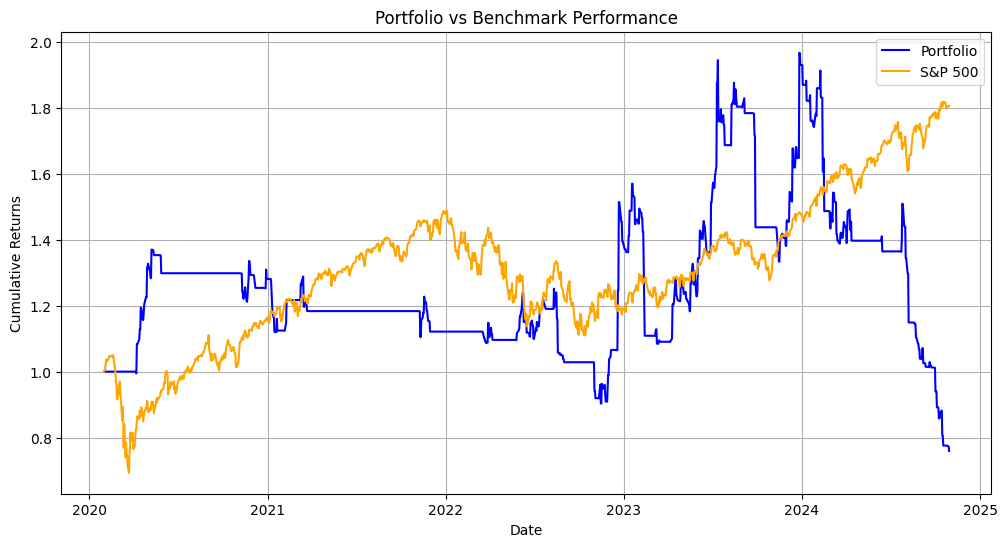

In [ ]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical price data from yfinance for benchmark
def fetch_benchmark_data(ticker, start_date, end_date):
    """
    Fetch historical benchmark data using yfinance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    if 'Adj Close' in data.columns:
        benchmark = data['Adj Close']
    else:
        benchmark = data['Close']
    benchmark.name = ticker
    return benchmark

# Load price data from CSV
def load_price_data(price_data_file):
    """
    Load historical price data from a CSV file.
    """
    if not os.path.exists(price_data_file):
        raise FileNotFoundError(f"Price data file '{price_data_file}' not found.")

    price_data = pd.read_csv(price_data_file, index_col='Datetime', parse_dates=True)
    price_data.sort_index(inplace=True)
    return price_data

# Dynamic position sizing based on volatility
def calculate_position_size(portfolio_value, price, volatility, target_risk=0.05):
    """
    Calculate the number of shares to buy based on target risk and volatility.
    """
    if volatility <= 0 or np.isnan(volatility):
        volatility = 0.02  # Default volatility to prevent division by zero

    target_allocation = target_risk / volatility
    allocation = portfolio_value * target_allocation
    shares_to_buy = int(allocation // price)

    return shares_to_buy

# Apply risk controls
def apply_risk_controls(price, entry_price, stop_loss=0.03, take_profit=0.06,
                        trailing_stop=None, max_price=None, volatility=None):
    """
    Apply risk control mechanisms to determine if a position should be sold.
    """
    # Adjust stop-loss and take-profit based on volatility
    if volatility is not None:
        stop_loss *= (1 + volatility)
        take_profit *= (1 + volatility)

    # Trailing stop-loss logic
    if trailing_stop is not None and max_price is not None:
        trailing_stop_price = max_price * (1 - trailing_stop)
        if price <= trailing_stop_price:
            print(f"Trailing Stop-Loss Triggered at {trailing_stop_price:.2f} with Current Price = {price:.2f}")
            return 'Trailing Stop'

    # Standard stop-loss and take-profit
    if price <= entry_price * (1 - stop_loss):
        print(f"Stop-Loss Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
        return 'Stop'  # Trigger a stop-loss
    elif price >= entry_price * (1 + take_profit):
        print(f"Take-Profit Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
        return 'Take Profit'  # Trigger a take-profit

    return 'Hold'

# Construct portfolio based on signals and apply risk controls
def construct_portfolio(price_data, signals_df, initial_investment=10000, transaction_cost=0.01,
                        target_risk=0.05, use_risk_controls=True, trailing_stop=None,
                        volatility_adjusted=True, time_exit_days=None):
    """
    Construct and manage a portfolio based on trading signals and risk controls.
    """
    cash = initial_investment
    portfolio = {}  # Holdings: {ticker: shares}
    entry_prices = {}  # Entry price per asset
    max_prices = {}  # Max price for trailing stop
    entry_dates = {}  # Entry dates for time-based exits
    daily_portfolio_value = []
    status = {}  # Status per asset: 'Bought', 'Sold', 'Hold'

    # Precompute volatility data if needed
    if volatility_adjusted:
        volatility_data = price_data.pct_change().rolling(window=20).std()
    else:
        volatility_data = pd.DataFrame(0.02, index=price_data.index, columns=price_data.columns)

    for date, row in signals_df.iterrows():
        if date not in price_data.index:
            continue  # Skip dates not in price data

        # Define tickers to buy, sell, and hold
        buy_tickers = row['Tickers to buy'].split(', ') if isinstance(row['Tickers to buy'], str) else []
        sell_tickers = row['Tickers to sell'].split(', ') if isinstance(row['Tickers to sell'], str) else []
        hold_tickers = row['Tickers to hold'].split(', ') if isinstance(row['Tickers to hold'], str) else []

        # Calculate current portfolio value
        portfolio_value = cash + sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        )

        # Buying logic with position sizing and status check
        for ticker in buy_tickers:
            if status.get(ticker, 'Sold') == 'Sold' and ticker in price_data.columns:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    # Calculate volatility and shares to buy based on target allocation
                    volatility = volatility_data.loc[date, ticker] if volatility_adjusted else 0.02
                    shares_to_buy = calculate_position_size(portfolio_value, price, volatility, target_risk=target_risk)
                    cost = price * shares_to_buy * (1 + transaction_cost)

                    if shares_to_buy > 0 and cash >= cost:
                        portfolio[ticker] = portfolio.get(ticker, 0) + shares_to_buy
                        entry_prices[ticker] = price  # Record entry price
                        max_prices[ticker] = price  # Set initial max price for trailing stop
                        entry_dates[ticker] = date  # Track entry date for time-based exit
                        cash -= cost
                        status[ticker] = 'Bought'
                        print(f"Bought {shares_to_buy} shares of {ticker} at {price:.2f} on {date.date()}, cost: {cost:.2f}")

        # Selling logic based on explicit sell signals
        for ticker in sell_tickers:
            if ticker in portfolio:
                price = price_data.loc[date, ticker]
                shares_to_sell = portfolio[ticker]
                income = shares_to_sell * price * (1 - transaction_cost)
                cash += income
                del portfolio[ticker]
                status[ticker] = 'Sold'
                print(f"Sold {shares_to_sell} shares of {ticker} at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Apply risk controls on existing positions
        for ticker in list(portfolio.keys()):
            price = price_data.loc[date, ticker]
            if not np.isnan(price) and ticker in entry_prices and use_risk_controls:
                # Update max price for trailing stop
                if trailing_stop is not None:
                    if price > max_prices.get(ticker, price):
                        max_prices[ticker] = price

                # Get volatility value
                volatility_value = volatility_data.loc[date, ticker] if volatility_adjusted else None

                # Apply risk controls
                risk_control_action = apply_risk_controls(
                    price,
                    entry_prices[ticker],
                    stop_loss=0.03,
                    take_profit=0.06,
                    trailing_stop=trailing_stop,
                    max_price=max_prices.get(ticker),
                    volatility=volatility_value
                )

                if risk_control_action in ['Stop', 'Take Profit', 'Trailing Stop']:
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]  # Remove from holdings
                    status[ticker] = 'Sold'
                    print(f"{risk_control_action} for {ticker}: Sold {shares_to_sell} shares at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Time-based exit logic
        for ticker in list(portfolio.keys()):
            if time_exit_days and (date - entry_dates[ticker]).days >= time_exit_days:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]
                    status[ticker] = 'Sold'
                    print(f"Time-Based Exit for {ticker}: Sold {shares_to_sell} shares at {price:.2f} on {date.date()}, income: {income:.2f}")

        # Track portfolio value for the day
        current_value = cash + sum(
            price_data.loc[date, ticker] * qty
            for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker])
        )
        daily_portfolio_value.append(current_value)
        print(f"End of {date.date()}: Cash: {cash:.2f}, Portfolio Value: {current_value:.2f}, Holdings: {portfolio}")

    # Convert daily portfolio values to a Series for easy analysis
    portfolio_values = pd.Series(daily_portfolio_value, index=signals_df.index)
    return portfolio_values

# Backtest performance evaluation
def calculate_performance(portfolio_values):
    """
    Calculate cumulative returns, Sharpe Ratio, and Max Drawdown.
    """
    returns = portfolio_values.pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return cumulative_returns, sharpe_ratio, max_drawdown

# Visualization of portfolio vs benchmark performance
def plot_performance(cumulative_returns, benchmark_returns, benchmark_name='Benchmark'):
    """
    Plot the cumulative returns of the portfolio and benchmark.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Portfolio', color='blue')
    plt.plot(benchmark_returns, label=benchmark_name, color='orange')
    plt.title('Portfolio vs Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main script
if __name__ == "__main__":
    # Define file paths
    price_data_file = "price_data.csv"  # Ensure this file exists in the working directory
    signals_file = "daily_buy_sell_hold_signals.csv"  # Ensure this file exists and is correctly formatted

    # Check if required files exist
    if not os.path.exists(price_data_file):
        print(f"Error: '{price_data_file}' not found.")
        exit()
    if not os.path.exists(signals_file):
        print(f"Error: '{signals_file}' not found.")
        exit()

    # Load price data
    price_data = load_price_data(price_data_file)
    print("Loaded price data.")

    # Load signals data
    signals_df = pd.read_csv(signals_file)
    signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])
    signals_df.set_index('Datetime', inplace=True)
    print("Loaded trading signals.")

    # Define date range and extract tickers from signals
    start_date, end_date = signals_df.index.min(), signals_df.index.max()
    tickers = list(set(
        ticker
        for col in ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']
        for tickers_list in signals_df[col].fillna('').apply(lambda x: x.split(', ') if x else [])
        for ticker in tickers_list
    ))
    print(f"Tickers extracted from signals: {tickers}")

    # Fetch benchmark data (e.g., S&P 500)
    benchmark_ticker = '^GSPC'  # S&P 500
    benchmark_data = fetch_benchmark_data(benchmark_ticker, start_date, end_date)
    print(f"Fetched benchmark data for {benchmark_ticker}.")

    # Align and clean data
    price_data = price_data.reindex(signals_df.index).fillna(method='ffill')
    benchmark_data = benchmark_data.reindex(signals_df.index).fillna(method='ffill')
    signals_df = signals_df[signals_df.index.isin(price_data.index)]
    print("Aligned and cleaned data.")

    # Construct portfolio and calculate returns
    portfolio_values = construct_portfolio(
        price_data=price_data,
        signals_df=signals_df,
        initial_investment=10000,
        transaction_cost=0.001,
        target_risk=0.05,
        use_risk_controls=True,
        trailing_stop=0.01,  # 3% trailing stop-loss
        volatility_adjusted=True,
        time_exit_days=15  # Exit positions after 15 days
    )
    print("Constructed portfolio and calculated daily values.")

    # Benchmark cumulative returns
    benchmark_returns = (1 + benchmark_data.pct_change().fillna(0)).cumprod()

    # Performance evaluation
    cumulative_returns, sharpe_ratio, max_drawdown = calculate_performance(portfolio_values)
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot performance
    plot_performance(cumulative_returns, benchmark_returns, benchmark_name='S&P 500')


[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-73-2a5d17729d42>:170: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.reindex(signals_df.index).fillna(method='ffill')


Sharpe Ratio: nan
Max Drawdown: nan%


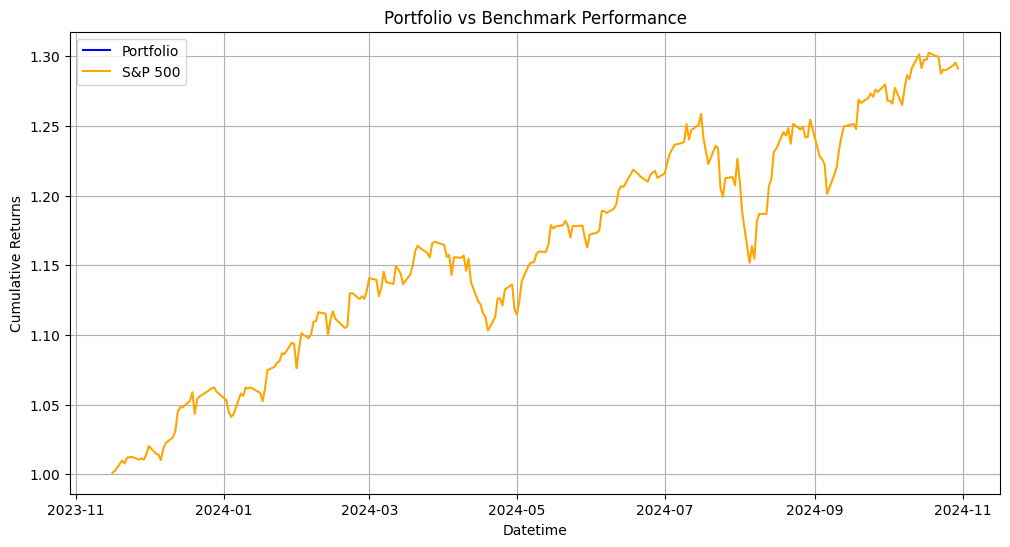

In [ ]:

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical price data
def fetch_data(tickers, start_date, end_date):
    price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return price_data

# Dynamic position sizing based on volatility
def calculate_position_size(portfolio_value, price, volatility, target_risk=0.05):
    target_allocation = target_risk / volatility
    allocation = portfolio_value * target_allocation
    shares_to_buy = int(allocation // price)
    return shares_to_buy

# Enhanced risk control function with logging
# Enhanced risk control function with optional trailing stop-loss and dynamic thresholds
def apply_risk_controls(price, entry_price, stop_loss=0.05, take_profit=0.1, trailing_stop=True, max_price=True, volatility=True):
    # Adjust stop-loss and take-profit based on volatility (if provided)
    if volatility is not None:
        stop_loss *= (1 + volatility)
        take_profit *= (1 + volatility)

    # Trailing stop-loss logic
    if trailing_stop and max_price:
        trailing_stop_price = max_price * (1 - trailing_stop)
        if price <= trailing_stop_price:
            print(f"Trailing Stop-Loss Triggered at {trailing_stop_price} with Current Price = {price}")
            return 'Trailing Stop'

    # Standard stop-loss and take-profit
    if price <= entry_price * (1 - stop_loss):
        print(f"Stop-Loss Triggered: Current Price = {price}, Entry Price = {entry_price}")
        return 'Stop'  # Trigger a stop-loss
    elif price >= entry_price * (1 + take_profit):
        print(f"Take-Profit Triggered: Current Price = {price}, Entry Price = {entry_price}")
        return 'Take Profit'  # Trigger a take-profit

    return 'Hold'


def construct_portfolio(price_data, signals_df, initial_investment=10000, transaction_cost=0.01,
                        target_allocation=0.05, use_risk_controls=True, trailing_stop=None,
                        volatility_adjusted=True, time_exit_days=None):
    cash = initial_investment
    portfolio = {}  # Track holdings: {ticker: shares}
    entry_prices = {}  # Track entry price per asset
    max_prices = {}  # Track max price for trailing stop
    entry_dates = {}  # Track entry dates for time-based exits
    daily_portfolio_value = []
    status = {}  # Track each asset's status ('Bought', 'Sold', 'Hold')

    for date, row in signals_df.iterrows():
        if date not in price_data.index:
            continue

        # Define tickers to buy, sell, and hold
        buy_tickers = row['Tickers to buy'].split(', ') if isinstance(row['Tickers to buy'], str) else []
        sell_tickers = row['Tickers to sell'].split(', ') if isinstance(row['Tickers to sell'], str) else []
        hold_tickers = row['Tickers to hold'].split(', ') if isinstance(row['Tickers to hold'], str) else []

        # Calculate current portfolio value
        portfolio_value = cash + sum(price_data.loc[date, ticker] * qty for ticker, qty in portfolio.items()
                                     if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker]))

        # Buying logic with position sizing and status check
        for ticker in buy_tickers:
            if status.get(ticker, 'Sold') == 'Sold' and ticker in price_data.columns:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    # Calculate volatility and shares to buy based on target allocation
                    volatility = price_data[ticker].pct_change().rolling(window=20).std().iloc[-1] if volatility_adjusted else None
                    shares_to_buy = calculate_position_size(portfolio_value, price, volatility or 0.02)
                    cost = price * shares_to_buy * (1 + transaction_cost)

                    if shares_to_buy > 0 and cash >= cost:
                        portfolio[ticker] = portfolio.get(ticker, 0) + shares_to_buy
                        entry_prices[ticker] = price  # Record entry price
                        max_prices[ticker] = price  # Set initial max price for trailing stop
                        entry_dates[ticker] = date  # Track entry date for time-based exit
                        cash -= cost
                        status[ticker] = 'Bought'
                        print(f"Bought {shares_to_buy} shares of {ticker} at {price} on {date}, cost: {cost:.2f}")

        # Check for risk control (stop-loss, take-profit, or trailing stop) on existing positions
        for ticker in list(portfolio.keys()):
            price = price_data.loc[date, ticker]
            if not np.isnan(price) and ticker in entry_prices and use_risk_controls:
                # Update max price for trailing stop
                if trailing_stop and price > max_prices[ticker]:
                    max_prices[ticker] = price

                # Apply risk controls with optional trailing stop and volatility adjustment
                risk_control_action = apply_risk_controls(price, entry_prices[ticker], stop_loss=0.05,
                                                          take_profit=0.1, trailing_stop=trailing_stop,
                                                          max_price=max_prices[ticker] if trailing_stop else None,
                                                          volatility=volatility if volatility_adjusted else None)

                if risk_control_action in ['Stop', 'Take Profit', 'Trailing Stop']:
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]  # Remove from holdings
                    status[ticker] = 'Sold'
                    print(f"{risk_control_action} for {ticker}: Sold {shares_to_sell} shares at {price} on {date}, income: {income:.2f}")

        # Time-based exit logic
        for ticker in list(portfolio.keys()):
            if time_exit_days and (date - entry_dates[ticker]).days >= time_exit_days:
                price = price_data.loc[date, ticker]
                if not np.isnan(price):
                    shares_to_sell = portfolio[ticker]
                    income = shares_to_sell * price * (1 - transaction_cost)
                    cash += income
                    del portfolio[ticker]
                    status[ticker] = 'Sold'
                    print(f"Time-Based Exit for {ticker}: Sold {shares_to_sell} shares at {price} on {date}, income: {income:.2f}")

        # Track portfolio value for the day
        current_value = cash + sum(price_data.loc[date, ticker] * qty for ticker, qty in portfolio.items()
                                   if ticker in price_data.columns and not np.isnan(price_data.loc[date, ticker]))
        daily_portfolio_value.append(current_value)
        print(f"End of {date}: Cash: {cash:.2f}, Portfolio Value: {current_value:.2f}, Holdings: {portfolio}")

    # Convert daily portfolio values to a Series for easy analysis
    return pd.Series(daily_portfolio_value, index=signals_df.index)


# Backtest performance evaluation
def calculate_performance(portfolio_values):
    returns = portfolio_values.pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return cumulative_returns, sharpe_ratio, max_drawdown

# Visualization of portfolio vs benchmark performance
def plot_performance(cumulative_returns, benchmark_returns, benchmark_name='Benchmark'):
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Portfolio', color='blue')
    plt.plot(benchmark_returns, label=benchmark_name, color='orange')
    plt.title('Portfolio vs Benchmark Performance')
    plt.xlabel('Datetime')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load signal data
    signals_df = pd.read_csv("daily_buy_sell_hold_signals.csv")
    signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])
    signals_df.set_index('Datetime', inplace=True)

    # Define date range and tickers from signals
    start_date, end_date = signals_df.index.min(), signals_df.index.max()
    tickers = list(set(ticker for col in ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']
                       for tickers in signals_df[col].fillna('').apply(lambda x: x.split(', ') if x else [])
                       for ticker in tickers))

    # Fetch price data and benchmark data
    price_data = fetch_data(tickers, start_date, end_date)
    benchmark_data = fetch_data(['^GSPC'], start_date, end_date)

    # Align and clean data
    signals_df = signals_df[signals_df.index.isin(price_data.index)]
    price_data = price_data.reindex(signals_df.index).fillna(method='ffill')

    # Construct portfolio and calculate returns
# Example: Construct portfolio with advanced risk controls
    portfolio_values = construct_portfolio(price_data, signals_df, initial_investment=10000, transaction_cost=0.01,
                                          target_allocation=0.05, use_risk_controls=True, trailing_stop=0.05,
                                          volatility_adjusted=True, time_exit_days=30)
    benchmark_returns = (1 + benchmark_data['^GSPC'].pct_change().dropna()).cumprod()

    # Performance evaluation
    cumulative_returns, sharpe_ratio, max_drawdown = calculate_performance(portfolio_values)
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot performance
    plot_performance(cumulative_returns, benchmark_returns, benchmark_name='S&P 500')


In [ ]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import deap

ModuleNotFoundError: No module named 'deap'

In [ ]:
def fitness_function(params, price_data, signals_df):
    # Unpack parameters
    target_risk, stop_loss, take_profit, trailing_stop, time_exit_days = params

    # Construct portfolio with given parameters
    portfolio_values = construct_portfolio(
        price_data, signals_df,
        initial_investment=10000,
        transaction_cost=0.01,
        target_allocation=target_risk,
        use_risk_controls=True,
        trailing_stop=trailing_stop,
        volatility_adjusted=True,
        time_exit_days=time_exit_days
    )

    # Evaluate performance
    cumulative_returns, sharpe_ratio, max_drawdown = calculate_performance(portfolio_values)

    # Define fitness (e.g., maximize Sharpe ratio, minimize drawdown)
    fitness = sharpe_ratio - max_drawdown  # Example fitness function

    return fitness,
from deap import base, creator, tools, algorithms

# Define the fitness function to be maximized
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Parameter ranges
toolbox.register("target_risk", np.random.uniform, 0.01, 0.1)  # Example range
toolbox.register("stop_loss", np.random.uniform, 0.01, 0.1)
toolbox.register("take_profit", np.random.uniform, 0.01, 0.2)
toolbox.register("trailing_stop", np.random.uniform, 0.01, 0.1)
toolbox.register("time_exit_days", np.random.randint, 5, 60)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.target_risk, toolbox.stop_loss, toolbox.take_profit,
                  toolbox.trailing_stop, toolbox.time_exit_days), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function, price_data=price_data, signals_df=signals_df)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
population = toolbox.population(n=50)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=True)


#OWN MODEL For Portfolio Trading- Working FinalPart

In [ ]:
tickers = ["BABA", "JD", "FOUR", "BIDU", "MOH", "OLPX", "REAL", "ACIC", "HPP", "BCAB"]


[*********************100%***********************]  1 of 1 completed
<ipython-input-57-8073aa6ca3ae>:402: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_returns = benchmark_returns.reindex(portfolio_values.index, method='ffill').fillna(method='bfill')


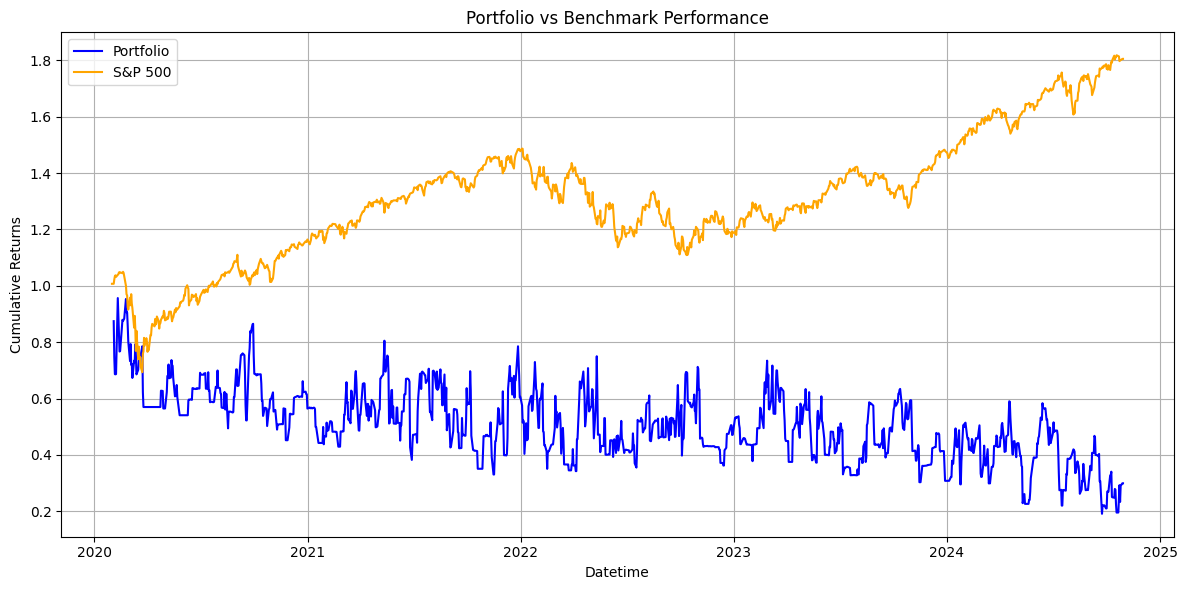

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

price_data_file = "price_data.csv"

# Fetch historical price data
def fetch_data(price_data_file):

    if not os.path.exists(price_data_file):
        logging.error(f"Price data file '{price_data_file}' not found.")
        raise FileNotFoundError(f"Price data file '{price_data_file}' not found.")

    try:
        price_data = pd.read_csv(price_data_file, index_col='Datetime', parse_dates=True)
        price_data.sort_index(inplace=True)
    except Exception as e:
        logging.error(f"Error reading '{price_data_file}': {e}")
        raise
    return price_data

def fetch_benchmark_data(ticker, start_date, end_date):

    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if 'Adj Close' in data.columns:
            benchmark = data['Adj Close']
        else:
            benchmark = data['Close']
        benchmark.name = ticker if isinstance(ticker, str) else ','.join(ticker)
    except Exception as e:
        logging.error(f"Error fetching benchmark data for '{ticker}': {e}")
        raise
    return benchmark

def calculate_position_size(portfolio_value, price, volatility, target_risk=0.05, leverage=1):

    if volatility == 0:
        logging.warning("Volatility is zero. Defaulting to minimum position size.")
        return 0
    target_allocation = (target_risk / volatility) * leverage
    allocation = portfolio_value * target_allocation
    shares_to_buy = int(allocation // price)
    return shares_to_buy

def apply_risk_controls(price, entry_price, stop_loss=0.05, take_profit=0.1, volatility=None):

    if volatility is not None:
        stop_loss_adj = stop_loss * (1 + volatility)
        take_profit_adj = take_profit * (1 + volatility)
    else:
        stop_loss_adj = stop_loss
        take_profit_adj = take_profit

    if price <= entry_price * (1 - stop_loss_adj):
        logging.info(f"Stop-Loss Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
        return 'Stop'
    elif price >= entry_price * (1 + take_profit_adj):
        logging.info(f"Take-Profit Triggered: Current Price = {price:.2f}, Entry Price = {entry_price:.2f}")
        return 'Take Profit'
    return 'Hold'

def calculate_transaction_cost(price, shares, cost_percentage=0.01):

    return price * shares * cost_percentage

def get_volatility(price_series, date, window=20):

    if date not in price_series.index:
        logging.warning(f"Date {date} not in price series. Returning default volatility.")
        return 0.02
    if price_series.index.get_loc(date) < window - 1:
        return 0.02  # Default volatility
    volatility = price_series.pct_change().rolling(window=window).std().loc[date]
    return volatility if not pd.isna(volatility) else 0.02

def construct_portfolio(price_data, signals_df, initial_investment=10000, transaction_cost=0.01,
                        target_allocation=0.05, max_short_allocation=0.1, max_shares_per_asset=100,
                        cooldown_period=5, volatility_adjusted=True, trailing_stop=False, time_exit_days=None):

    cash = initial_investment
    portfolio = {}  # Long positions
    short_positions = {}  # Short positions
    entry_prices = {}
    entry_dates = {}
    cooldown_tracker = {}
    daily_portfolio_value = []
    status = {}  # Status of each asset

    for date, row in signals_df.iterrows():
        if date not in price_data.index:
            logging.warning(f"Date {date} not in price data. Skipping.")
            continue

        # Parse signals
        buy_tickers = row['Tickers to buy'].split(', ') if isinstance(row['Tickers to buy'], str) else []
        sell_tickers = row['Tickers to sell'].split(', ') if isinstance(row['Tickers to sell'], str) else []
        hold_tickers = row['Tickers to hold'].split(', ') if isinstance(row['Tickers to hold'], str) else []
        # If short selling is distinct, handle 'Tickers to short' similarly

        # Update cooldowns
        for ticker in list(cooldown_tracker.keys()):
            if date >= cooldown_tracker[ticker]:
                del cooldown_tracker[ticker]

        # Calculate current portfolio value
        portfolio_value = cash + sum(
            price_data.at[date, ticker] * qty for ticker, qty in portfolio.items()
            if ticker in price_data.columns and not pd.isna(price_data.at[date, ticker])
        )

        # Unrealized gains from short positions
        for ticker, shares in short_positions.items():
            price = price_data.at[date, ticker]
            entry_price = entry_prices[ticker]
            if ticker in price_data.columns and not pd.isna(price):
                unrealized_gain = (entry_price - price) * shares
                portfolio_value += unrealized_gain

        # Buying logic
        for ticker in buy_tickers:
            if status.get(ticker, 'Sold') == 'Sold' and ticker in price_data.columns:
                price = price_data.at[date, ticker]
                if pd.isna(price):
                    logging.warning(f"[{date}] Price for {ticker} is NaN. Skipping buy.")
                    continue

                # Check cooldown
                if ticker in cooldown_tracker:
                    logging.info(f"[{date}] {ticker} is in cooldown until {cooldown_tracker[ticker]}. Skipping buy.")
                    continue

                # Calculate volatility and position size
                if volatility_adjusted:
                    volatility = get_volatility(price_data[ticker], date)
                else:
                    volatility = 0.02

                shares_to_buy = calculate_position_size(portfolio_value, price, volatility, target_risk=target_allocation)
                cost = price * shares_to_buy + calculate_transaction_cost(price, shares_to_buy, transaction_cost)

                if shares_to_buy > 0 and cash >= cost:
                    portfolio[ticker] = portfolio.get(ticker, 0) + shares_to_buy
                    entry_prices[ticker] = price
                    entry_dates[ticker] = date
                    cash -= cost
                    status[ticker] = 'Bought'
                    logging.info(f"[{date}] Bought {shares_to_buy} shares of {ticker} at {price:.2f}, cost: {cost:.2f}")
                else:
                    logging.info(f"[{date}] Not enough cash to buy {shares_to_buy} shares of {ticker}.")

        # Selling logic (closing long positions)
        for ticker in sell_tickers:
            if ticker in portfolio and ticker in price_data.columns:
                price = price_data.at[date, ticker]
                if pd.isna(price):
                    logging.warning(f"[{date}] Price for {ticker} is NaN. Skipping sell.")
                    continue

                shares_to_sell = portfolio[ticker]
                income = shares_to_sell * price - calculate_transaction_cost(price, shares_to_sell, transaction_cost)
                cash += income
                del portfolio[ticker]
                status[ticker] = 'Sold'
                cooldown_tracker[ticker] = date + pd.Timedelta(days=cooldown_period)
                logging.info(f"[{date}] Sold {shares_to_sell} shares of {ticker} at {price:.2f}, income: {income:.2f}")

        # Short selling logic
        for ticker in sell_tickers:
            if ticker not in portfolio and ticker not in short_positions and ticker in price_data.columns:
                price = price_data.at[date, ticker]
                if pd.isna(price):
                    logging.warning(f"[{date}] Price for {ticker} is NaN. Skipping short sell.")
                    continue

                # Check cooldown
                if ticker in cooldown_tracker:
                    logging.info(f"[{date}] {ticker} is in cooldown until {cooldown_tracker[ticker]}. Skipping short sell.")
                    continue

                # Calculate shares to short
                shares_to_short = min(int((max_short_allocation * initial_investment) // price), max_shares_per_asset)
                if shares_to_short > 0:
                    short_positions[ticker] = shares_to_short
                    entry_prices[ticker] = price
                    entry_dates[ticker] = date
                    proceeds = shares_to_short * price - calculate_transaction_cost(price, shares_to_short, transaction_cost)
                    cash += proceeds  # Receive cash from short selling
                    status[ticker] = 'Shorted'
                    logging.info(f"[{date}] Shorted {shares_to_short} shares of {ticker} at {price:.2f}, proceeds: {proceeds:.2f}")

        # Risk control for long positions
        for ticker in list(portfolio.keys()):
            price = price_data.at[date, ticker]
            if pd.isna(price) or ticker not in entry_prices:
                continue

            # Apply risk controls
            if volatility_adjusted:
                volatility = get_volatility(price_data[ticker], date)
            else:
                volatility = None

            risk_control_action = apply_risk_controls(
                price, entry_prices[ticker], stop_loss=0.05,
                take_profit=0.1, volatility=volatility
            )

            if risk_control_action in ['Stop', 'Take Profit']:
                shares_to_sell = portfolio[ticker]
                income = shares_to_sell * price - calculate_transaction_cost(price, shares_to_sell, transaction_cost)
                cash += income
                del portfolio[ticker]
                status[ticker] = 'Sold'
                cooldown_tracker[ticker] = date + pd.Timedelta(days=cooldown_period)
                logging.info(f"[{date}] {risk_control_action} for {ticker}: Sold {shares_to_sell} shares at {price:.2f}, income: {income:.2f}")

        # Risk control for short positions
        for ticker in list(short_positions.keys()):
            price = price_data.at[date, ticker]
            if pd.isna(price) or ticker not in entry_prices:
                continue

            # Reverse logic for short positions
            stop_loss_price = entry_prices[ticker] * (1 + 0.05)
            take_profit_price = entry_prices[ticker] * (1 - 0.1)
            action = 'Hold'

            if price >= stop_loss_price:
                action = 'Stop'
            elif price <= take_profit_price:
                action = 'Take Profit'

            if action in ['Stop', 'Take Profit']:
                shares_to_cover = short_positions[ticker]
                cost = shares_to_cover * price + calculate_transaction_cost(price, shares_to_cover, transaction_cost)
                cash -= cost
                del short_positions[ticker]
                status[ticker] = 'Covered'
                cooldown_tracker[ticker] = date + pd.Timedelta(days=cooldown_period)
                logging.info(f"[{date}] {action} for {ticker}: Covered {shares_to_cover} shares at {price:.2f}, cost: {cost:.2f}")

        # Time-based exit for long positions
        for ticker in list(portfolio.keys()):
            if time_exit_days and (date - entry_dates[ticker]).days >= time_exit_days:
                price = price_data.at[date, ticker]
                if pd.isna(price):
                    logging.warning(f"[{date}] Price for {ticker} is NaN. Skipping time-based exit.")
                    continue

                shares_to_sell = portfolio[ticker]
                income = shares_to_sell * price - calculate_transaction_cost(price, shares_to_sell, transaction_cost)
                cash += income
                del portfolio[ticker]
                status[ticker] = 'Sold'
                cooldown_tracker[ticker] = date + pd.Timedelta(days=cooldown_period)
                logging.info(f"[{date}] Time-Based Exit for {ticker}: Sold {shares_to_sell} shares at {price:.2f}, income: {income:.2f}")

        # Time-based exit for short positions
        for ticker in list(short_positions.keys()):
            if time_exit_days and (date - entry_dates[ticker]).days >= time_exit_days:
                price = price_data.at[date, ticker]
                if pd.isna(price):
                    logging.warning(f"[{date}] Price for {ticker} is NaN. Skipping time-based exit for short.")
                    continue

                shares_to_cover = short_positions[ticker]
                cost = shares_to_cover * price + calculate_transaction_cost(price, shares_to_cover, transaction_cost)
                cash -= cost
                del short_positions[ticker]
                status[ticker] = 'Covered'
                cooldown_tracker[ticker] = date + pd.Timedelta(days=cooldown_period)
                logging.info(f"[{date}] Time-Based Exit for {ticker}: Covered {shares_to_cover} shares at {price:.2f}, cost: {cost:.2f}")

        # Calculate current portfolio value
        portfolio_value = cash

        # Add market value of long positions
        for ticker, shares in portfolio.items():
            price = price_data.at[date, ticker]
            if ticker in price_data.columns and not pd.isna(price):
                portfolio_value += price * shares

        # Add unrealized gains/losses from short positions
        for ticker, shares in short_positions.items():
            price = price_data.at[date, ticker]
            entry_price = entry_prices[ticker]
            if ticker in price_data.columns and not pd.isna(price):
                unrealized_gain = (entry_price - price) * shares
                portfolio_value += unrealized_gain

        daily_portfolio_value.append(portfolio_value)
        logging.info(f"[{date}] End of Day: Cash: {cash:.2f}, Portfolio Value: {portfolio_value:.2f}, Holdings: {portfolio}, Short Positions: {short_positions}")

    # Convert daily portfolio values to a Series for easy analysis
    return pd.Series(daily_portfolio_value, index=signals_df.index)

def calculate_performance(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values (pd.Series): Daily portfolio values.

    Returns:
    - tuple: Cumulative returns, Sharpe ratio, and max drawdown.
    """
    returns = portfolio_values.pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod()
    if returns.std() == 0:
        sharpe_ratio = np.nan
        logging.warning("Standard deviation of returns is zero. Sharpe ratio is undefined.")
    else:
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return cumulative_returns, sharpe_ratio, max_drawdown

def plot_performance(cumulative_returns, benchmark_returns, benchmark_name='Benchmark'):
    """
    Plots the portfolio's cumulative returns against a benchmark.

    Parameters:
    - cumulative_returns (pd.Series): Portfolio's cumulative returns.
    - benchmark_returns (pd.Series): Benchmark's cumulative returns.
    - benchmark_name (str): Name of the benchmark (default is 'Benchmark').
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Portfolio', color='blue')
    plt.plot(benchmark_returns, label=benchmark_name, color='orange')
    plt.title('Portfolio vs Benchmark Performance')
    plt.xlabel('Datetime')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    try:
        # Load signal data
        signals_df = pd.read_csv("daily_buy_sell_hold_signals.csv")
        signals_df['Datetime'] = pd.to_datetime(signals_df['Datetime'])
        signals_df.set_index('Datetime', inplace=True)

        # Validate signal data
        required_columns = ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']
        missing_columns = set(required_columns) - set(signals_df.columns)
        if missing_columns:
            raise ValueError(f"Missing columns in signals data: {missing_columns}")

        # Define tickers from signals
        tickers = list(set(
            ticker for col in ['Tickers to buy', 'Tickers to sell', 'Tickers to hold']
            for tickers in signals_df[col].fillna('').apply(lambda x: x.split(', ') if x else [])
            for ticker in tickers
        ))

        # Correct ticker symbols for yfinance (replace '/' with '-')
        tickers = [ticker.replace('/', '-') for ticker in tickers]

        # Fetch price data and benchmark data
        start_date, end_date = signals_df.index.min(), signals_df.index.max()
        price_data = fetch_data(price_data_file)
        benchmark_data = fetch_benchmark_data('^GSPC', start_date, end_date)  # S&P 500 as benchmark

        # Handle missing data
        price_data = price_data.reindex(signals_df.index).ffill().bfill()

        # Ensure there are no remaining NaNs
        if price_data.isna().sum().sum() > 0:
            logging.warning("There are still NaN values in price_data after filling. Dropping these rows.")
            price_data = price_data.dropna()

        signals_df = signals_df.loc[price_data.index]

        # Construct portfolio and calculate returns
        portfolio_values = construct_portfolio(
            price_data,
            signals_df,
            initial_investment=10000,
            transaction_cost=0.01,
            target_allocation=0.05,
            max_short_allocation=0.1,
            max_shares_per_asset=100,
            cooldown_period=5,
            volatility_adjusted=True,
            trailing_stop=False,  # Disabled trailing stop
            time_exit_days=30
        )

        # Benchmark cumulative returns
        benchmark_returns = (1 + benchmark_data.pct_change().dropna()).cumprod()

        # Align benchmark with portfolio
        benchmark_returns = benchmark_returns.reindex(portfolio_values.index, method='ffill').fillna(method='bfill')

        # Performance evaluation
        cumulative_returns, sharpe_ratio, max_drawdown = calculate_performance(portfolio_values)
        logging.info(f"\nSharpe Ratio: {sharpe_ratio:.2f}")
        logging.info(f"Max Drawdown: {max_drawdown:.2%}")

        # Plot performance
        plot_performance(cumulative_returns, benchmark_returns, benchmark_name='S&P 500')

    except Exception as e:
        logging.error(f"An error occurred during execution: {e}")


Potential Issues and Considerations
Data Alignment:

Ensure that price data and signals are properly aligned and that missing data is handled.
Overfitting:

Be cautious of overfitting the strategy to historical data. Implement cross-validation or walk-forward analysis.
Transaction Costs and Slippage:

Factor in realistic transaction costs and market impact, especially when trading with leverage.
Regulatory Compliance:

If implementing short selling and leverage, consider any regulatory constraints and margin requirements.

In [ ]:
%who

Counter	 RandomForestRegressor	 TimeSeriesSplit	 aggregate_daily_signals	 apply_risk_controls	 backtest	 batch_size	 benchmark_data	 benchmark_returns	 
calculate_adaptive_weights	 calculate_indicators	 calculate_performance	 calculate_position_size	 calculate_transaction_cost	 column	 construct_portfolio	 cumulative_returns	 data	 
data_file_path	 df	 efficient_indicators	 end_date	 essential_columns	 fast_window	 feature_dir	 feature_files_dir	 features_file	 
features_folder	 fetch_benchmark_data	 fetch_data	 fred_api_key	 fundamental_data_path	 generate_adaptive_signal	 generate_dynamic_signals	 generate_signals_and_backtest	 get_selected_indicators	 
get_volatility	 glob	 indicator_keys	 initial_balance	 interval	 learning_rate	 load_and_preprocess_data	 load_existing_summary	 load_price_data	 
load_signals	 logger	 logging	 lookback	 macro_file	 main	 max_drawdown	 mean_squared_error	 metrics_file	 
missing_columns	 n_epochs	 n_layers	 n_neurons	 n_window_size	 np	 os	 output_dir

In [ ]:

start_date = '2018-01-01'
end_date = '2024-10-31'
interval = '1d'
lookback = 60
fred_api_key = "4900ff387674e4637fb09b7e6fe5faf8"

    # File and folder paths
features_folder = "/content"
targets_folder = "/content"
output_features_folder = "/content/merged_features"
output_targets_folder = "/content/merged_targets"
output_folder = "/content/ticker_models"  # Corrected to match references in your scripts

    # Model and training parameters
n_window_size = 20
n_neurons = 200
n_layers = 2
learning_rate = 0.001
n_epochs = 15
batch_size = 15
initial_balance = 100000

    # Combined features and targets files
features_file = "merged_features/combined_features.csv"
targets_file = "merged_targets/combined_targets.csv"

    # Fundamental data paths
fundamental_data_path = "/content/drive/MyDrive/Colab Data/DATA WRDS/wrdsapps_finratio.csv"
metrics_file = "/content/drive/MyDrive/Colab Data/DATA WRDS/selected_financial_metrics_list.csv"
macro_file = "/content/drive/MyDrive/Colab Data/DATA WRDS/macro_data.csv"

#VECTOR BT portfolio

In [ ]:
!pip install vectorbt

In [ ]:
price_data = 'price_data.csv'

In [ ]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import yfinance as yf
# Example price data for multiple tickers


# Define multiple moving average strategy configurations
fast_window = np.arange(5, 20, 5)
slow_window = np.arange(20, 100, 20)

entries = price_data.vbt.signals.generate(
    vbt.MA.run(price_data, fast_window).out_crossed_above(vbt.MA.run(price_data, slow_window).out),
    vbt.MA.run(price_data, fast_window).out_crossed_below(vbt.MA.run(price_data, slow_window).out)
)

# Run the backtest
portfolio = vbt.Portfolio.from_signals(price_data, entries=entries, short_entries=entries)
portfolio_stats = portfolio.stats()
print(portfolio_stats)
portfolio.plot().show()


AttributeError: 'str' object has no attribute 'vbt'

# Backtrader Portfolio

In [ ]:
pip install backtrader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import backtrader as bt
import pandas as pd
import yfinance as yf
import datetime


NameError: name 'signals' is not defined

In [ ]:
import os
import pandas as pd
import backtrader as bt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
class SignalStrategy(bt.Strategy):
    params = (
        ('short_threshold', 10),
        ('trailing_stop', 0.01),
        ('stop_loss', 0.03),
        ('take_profit', 0.06),
        ('time_exit_days', 15),
        ('transaction_cost', 0.001),
    )

    def __init__(self, signals):
        self.signals = signals
        self.sell_signal_counts = {}
        self.position_entry_dates = {}

    def next(self):
        # Get the current date
        date = self.datas[0].datetime.date(0)

        # Fetch today's signals
        if date not in self.signals.index:
            return  # Skip if no signals for this date

        signals_today = self.signals.loc[date]

        # Parse tickers
        buy_tickers = signals_today['Tickers to buy'].split(', ') if signals_today['Tickers to buy'] else []
        sell_tickers = signals_today['Tickers to sell'].split(', ') if signals_today['Tickers to sell'] else []

        # Execute buy signals
        for ticker in buy_tickers:
            if self.getpositionbyname(ticker).size == 0:  # Only buy if not already in position
                self.buy(data=self.getdatabyname(ticker))
                print(f"Buying {ticker} on {date}")

        # Execute sell signals
        for ticker in sell_tickers:
            pos = self.getpositionbyname(ticker)
            if pos.size > 0:  # Close long position
                self.sell(data=self.getdatabyname(ticker), size=pos.size)
                print(f"Selling {ticker} on {date}")
            elif pos.size < 0:  # Cover short position
                self.buy(data=self.getdatabyname(ticker), size=abs(pos.size))
                print(f"Covering short {ticker} on {date}")


    def getpositionbyname(self, ticker):
        for d in self.datas:
            if d._name == ticker:
                return self.getposition(d)
        return None

    def buy_position(self, ticker):
        size = self.calculate_size(ticker)
        if size > 0:
            self.buy(data=self.getdatabyname(ticker), size=size)
            self.position_entry_dates[ticker] = self.datas[0].datetime.date(0)
            logging.info(f"Bought {size} shares of {ticker} on {self.datas[0].datetime.date(0)}")

    def sell_position(self, ticker):
        pos = self.getpositionbyname(ticker)
        if pos and pos.size > 0:
            self.sell(data=self.getdatabyname(ticker), size=pos.size)
            logging.info(f"Sold {pos.size} shares of {ticker} on {self.datas[0].datetime.date(0)}")

    def short_position(self, ticker):
        size = self.calculate_size(ticker)
        if size > 0:
            self.sell(data=self.getdatabyname(ticker), size=size)
            self.position_entry_dates[ticker] = self.datas[0].datetime.date(0)
            logging.info(f"Shorted {size} shares of {ticker} on {self.datas[0].datetime.date(0)}")

    def cover_short_position(self, ticker):
        pos = self.getpositionbyname(ticker)
        if pos and pos.size < 0:
            self.buy(data=self.getdatabyname(ticker), size=abs(pos.size))
            logging.info(f"Covered short {abs(pos.size)} shares of {ticker} on {self.datas[0].datetime.date(0)}")

    def calculate_size(self, ticker):
        cash = self.broker.get_cash()
        price = self.getdatabyname(ticker).close[0]
        if price <= 0:
            return 0
        risk_amount = cash * 0.05  # 5% risk
        size = int((risk_amount) / price)
        return size

    def manage_position(self, ticker, pos, position_type):
        price = self.getdatabyname(ticker).close[0]
        entry_price = pos.price
        entry_date = self.position_entry_dates.get(ticker)

        # Update trailing stop
        if ticker not in self.trailing_stop_prices:
            self.trailing_stop_prices[ticker] = price
        else:
            if position_type == 'long' and price > self.trailing_stop_prices[ticker]:
                self.trailing_stop_prices[ticker] = price
            elif position_type == 'short' and price < self.trailing_stop_prices[ticker]:
                self.trailing_stop_prices[ticker] = price

        # Check stop-loss and take-profit
        if position_type == 'long':
            if price <= entry_price * (1 - self.params.stop_loss):
                self.sell_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Stop-Loss triggered for {ticker} on {self.datas[0].datetime.date(0)}")
                return
            if price >= entry_price * (1 + self.params.take_profit):
                self.sell_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Take-Profit triggered for {ticker} on {self.datas[0].datetime.date(0)}")
                return
            # Check trailing stop
            if price <= self.trailing_stop_prices[ticker] * (1 - self.params.trailing_stop):
                self.sell_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Trailing Stop triggered for {ticker} on {self.datas[0].datetime.date(0)}")
                return
            # Time-based exit
            if (self.datas[0].datetime.date(0) - entry_date).days >= self.params.time_exit_days:
                self.sell_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Time-Based Exit for {ticker} on {self.datas[0].datetime.date(0)}")
                return
        elif position_type == 'short':
            if price >= entry_price * (1 + self.params.stop_loss):
                self.cover_short_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Stop-Loss triggered for short {ticker} on {self.datas[0].datetime.date(0)}")
                return
            if price <= entry_price * (1 - self.params.take_profit):
                self.cover_short_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Take-Profit triggered for short {ticker} on {self.datas[0].datetime.date(0)}")
                return
            # Check trailing stop
            if price >= self.trailing_stop_prices[ticker] * (1 + self.params.trailing_stop):
                self.cover_short_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Trailing Stop triggered for short {ticker} on {self.datas[0].datetime.date(0)}")
                return
            # Time-based exit
            if (self.datas[0].datetime.date(0) - entry_date).days >= self.params.time_exit_days:
                self.cover_short_position(ticker)
                del self.trailing_stop_prices[ticker]
                logging.info(f"Time-Based Exit for short {ticker} on {self.datas[0].datetime.date(0)}")
                return

def run_backtest():
    cerebro = bt.Cerebro()

    # Set initial cash
    cerebro.broker.set_cash(10000)

    # Set commission
    cerebro.broker.setcommission(commission=0.001)  # 0.1%

    # Load price data
    price_data = pd.read_csv("price_data.csv", parse_dates=["Datetime"], index_col="Datetime")
    price_data.fillna(method='ffill', inplace=True)  # Forward-fill missing data
    price_data.fillna(method='bfill', inplace=True)  # Backfill missing data
    price_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
    price_data.dropna(inplace=True)  # Drop rows with NaN values

    # Add data feeds for each ticker
    for ticker in price_data.columns:
        data = bt.feeds.PandasData(dataname=price_data[[ticker]], name=ticker)
        cerebro.adddata(data)

    # Load signals data
    signals = pd.read_csv("daily_buy_sell_hold_signals.csv", parse_dates=["Datetime"], index_col="Datetime")
    signals.fillna('', inplace=True)  # Ensure no NaN values
    # Check alignment of price_data and signals
    if not price_data.index.equals(signals.index):
        print("Warning: Datetime indices in price_data and signals do not align!")
        price_data = price_data.reindex(signals.index).fillna(method="ffill").fillna(method="bfill")

    # Add strategy with the signals DataFrame
    cerebro.addstrategy(SignalStrategy, signals=signals)

    # Run backtest
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
    results = cerebro.run()
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

    # Extract portfolio value from broker
    final_value = cerebro.broker.getvalue()
    if not np.isfinite(final_value):
        raise ValueError("Final Portfolio Value is NaN or Inf. Check your data and logic.")

    # Plot results (ensure no NaN/Inf in portfolio values)
    try:
        cerebro.plot()
    except ValueError as e:
        print(f"Plotting failed: {e}")


if __name__ == "__main__":
    run_backtest()


<ipython-input-74-17319d640f60>:168: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='ffill', inplace=True)  # Forward-fill missing data
<ipython-input-74-17319d640f60>:169: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='bfill', inplace=True)  # Backfill missing data
<ipython-input-74-17319d640f60>:184: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.reindex(signals.index).fillna(method="ffill").fillna(method="bfill")


Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00
Plotting failed: Axis limits cannot be NaN or Inf


In [ ]:
print(self.signals.head())


NameError: name 'self' is not defined

#Diagnostics


In [ ]:
# List all variables and their types
for var_name, var_value in globals().items():
    print(f"{var_name}: {type(var_value)}")
import pandas as pd

# Filter variables to only show DataFrames
dataframes = {var_name: var_value for var_name, var_value in globals().items() if isinstance(var_value, pd.DataFrame)}

# Display DataFrame names and shapes
for df_name, df_value in dataframes.items():
    print(f"{df_name}: {df_value.shape}")
print(dir())


__name__: <class 'str'>
__doc__: <class 'str'>
__package__: <class 'NoneType'>
__loader__: <class 'NoneType'>
__spec__: <class 'NoneType'>
__builtin__: <class 'module'>
__builtins__: <class 'module'>
_ih: <class 'list'>
_oh: <class 'dict'>
_dh: <class 'list'>
In: <class 'list'>
Out: <class 'dict'>
get_ipython: <class 'method'>
exit: <class 'IPython.core.autocall.ZMQExitAutocall'>
quit: <class 'IPython.core.autocall.ZMQExitAutocall'>
_: <class 'str'>
__: <class 'str'>
___: <class 'str'>
_i: <class 'str'>
_ii: <class 'str'>
_iii: <class 'str'>
_i1: <class 'str'>
_i2: <class 'str'>
tickers: <class 'list'>
start_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
end_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
interval: <class 'str'>
lookback: <class 'int'>
fred_api_key: <class 'str'>
features_folder: <class 'str'>
targets_folder: <class 'str'>
output_features_folder: <class 'str'>
output_targets_folder: <class 'str'>
output_folder: <class 'str'>
n_window_size: <class 'in

In [ ]:
%whos


Variable                                Type         Data/Info
--------------------------------------------------------------
Counter                                 type         <class 'collections.Counter'>
RandomForestRegressor                   ABCMeta      <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
TimeSeriesSplit                         ABCMeta      <class 'sklearn.model_sel<...>._split.TimeSeriesSplit'>
aggregate_daily_signals                 function     <function aggregate_daily<...>ignals at 0x7d50cb41cc10>
apply_risk_controls                     function     <function apply_risk_controls at 0x7d5056866440>
backtest                                function     <function backtest at 0x7d5056aa7760>
batch_size                              int          15
benchmark_data                          DataFrame    Ticker                   <...>\n[1194 rows x 1 columns]
benchmark_returns                       DataFrame    Ticker                   <...>\n[1195 rows x 1 column

In [ ]:
print(price_data.head())


Ticker                          AAPL       AMZN       AVGO         BLK  \
Date                                                                     
2018-02-01 00:00:00+00:00  39.470428  69.500000  19.119453  474.510742   
2018-02-02 00:00:00+00:00  37.757801  71.497498  18.854429  460.347443   
2018-02-05 00:00:00+00:00  36.814449  69.500000  18.263519  440.743713   
2018-02-06 00:00:00+00:00  38.352978  72.141998  19.246754  449.349060   
2018-02-07 00:00:00+00:00  37.531952  70.838997  19.006557  446.864075   

Ticker                         GOOGL        JPM  KRRO        LLY       MSFT  \
Date                                                                          
2018-02-01 00:00:00+00:00  58.933567  96.384155   NaN  73.682861  87.332817   
2018-02-02 00:00:00+00:00  55.821774  94.248154   NaN  72.583115  85.035080   
2018-02-05 00:00:00+00:00  52.988293  89.728722   NaN  69.283890  81.532860   
2018-02-06 00:00:00+00:00  54.087570  92.458504   NaN  69.730949  84.618141   
2018-02

#  1

In [ ]:
# Load signal data
signals_df = pd.read_csv("daily_buy_sell_hold_signals.csv", parse_dates=['Datetime'], index_col='Datetime')

# Define tickers from signals
tickers = list(set(
    signal for sublist in signals_df[['Tickers to buy', 'Tickers to sell', 'Tickers to hold']].fillna('').values.flatten()
    for signal in sublist.split(', ') if signal
))

# Fetch price data
start_date = signals_df.index.min()
end_date = signals_df.index.max()
price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Ensure indices are datetime and timezone-naive
price_data.index = pd.to_datetime(price_data.index).tz_localize(None)
signals_df.index = pd.to_datetime(signals_df.index).tz_localize(None)

# Align indices
common_dates = price_data.index.intersection(signals_df.index)
price_data = price_data.loc[common_dates]
signals_df = signals_df.loc[common_dates]

# Prepare data for Backtrader
data_feeds = []

for ticker in tickers:
    # Extract closing price data for the ticker
    df_price = price_data[[ticker]].copy()
    df_price.columns = ['close']  # Rename the column to 'close'
    df_price.index.name = 'datetime'

    # Create a DataFrame for the signals
    df_signal = pd.DataFrame(index=df_price.index)
    df_signal['signal'] = 0  # Default to hold

    # Populate signals based on signals_df
    buy_mask = signals_df['Tickers to buy'].str.contains(ticker, na=False)
    sell_mask = signals_df['Tickers to sell'].str.contains(ticker, na=False)

    buy_dates = signals_df[buy_mask].index
    sell_dates = signals_df[sell_mask].index

    df_signal.loc[buy_dates, 'signal'] = 1
    df_signal.loc[sell_dates, 'signal'] = -1

    # Combine price data and signals
    df_combined = df_price.join(df_signal, how='left')
    df_combined['signal'].fillna(0, inplace=True)

    # Forward-fill missing prices
    df_combined['close'].fillna(method='ffill', inplace=True)

    # Drop any remaining rows with missing data
    df_combined.dropna(inplace=True)

    # Verify that there are no NaN values
    if df_combined['close'].isna().any():
        print(f"Warning: NaN values found in 'close' prices for {ticker} after filling.")
    # Check if df_combined is empty
    if df_combined.empty:
        print(f"Data for {ticker} is empty after combining. Skipping.")
        continue  # Skip this ticker
    print(f"First few rows of df_combined for {ticker}:\n{df_combined.head()}")
    print(f"Indices for {ticker} - Price Data: {df_price.index[:5]}, Signal Data: {df_signal.index[:5]}")
    print(f"Columns in signals_df: {signals_df.columns}")

    # Create a Backtrader data feed
    data_feed = ClosePriceData(
        dataname=df_combined,
        name=ticker,
        datetime=None,
        close='close',
        signal='signal',
        plot=False
    )
    data_feeds.append(data_feed)
print(f"Number of data feeds: {len(data_feeds)}")


[*********************100%***********************]  13 of 13 completed
<ipython-input-65-421e4ee68eb7>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['signal'].fillna(0, inplace=True)
<ipython-input-65-421e4ee68eb7>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

First few rows of df_combined for JPM:
                close  signal
datetime                     
2018-02-01  96.384155      -1
2018-02-02  94.248154      -1
2018-02-05  89.728722      -1
2018-02-06  92.458504      -1
2018-02-07  93.085312      -1
Indices for JPM - Price Data: DatetimeIndex(['2018-02-01', '2018-02-02', '2018-02-05', '2018-02-06',
               '2018-02-07'],
              dtype='datetime64[ns]', name='datetime', freq=None), Signal Data: DatetimeIndex(['2018-02-01', '2018-02-02', '2018-02-05', '2018-02-06',
               '2018-02-07'],
              dtype='datetime64[ns]', name='datetime', freq=None)
Columns in signals_df: Index(['Tickers to buy', 'Tickers to sell', 'Tickers to hold'], dtype='object')
First few rows of df_combined for GOOGL:
                close  signal
datetime                     
2018-02-01  58.933567      -1
2018-02-02  55.821774      -1
2018-02-05  52.988293      -1
2018-02-06  54.087570      -1
2018-02-07  52.640156      -1
Indices for GOOGL -

In [ ]:


import backtrader as bt
import datetime

# Initialize Cerebro
cerebro = bt.Cerebro()

# Set initial cash
initial_balance = 100000  # Ensure initial_balance is defined
cerebro.broker.setcash(initial_balance)

# Set commission (transaction cost)
transaction_cost = 0.001  # 0.1%
cerebro.broker.setcommission(commission=transaction_cost)

# Optionally set slippage
cerebro.broker.set_slippage_perc(perc=0.0005)  # 0.05% slippage

# Add data feeds
for data_feed in data_feeds:
    cerebro.adddata(data_feed)

print(f"Number of data feeds: {len(data_feeds)}")
print(f"Tickers: {tickers}")

# Add strategy
cerebro.addstrategy(MyStrategy)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

# Run backtest
try:
    results = cerebro.run()
except Exception as e:
    print(f"An exception occurred during backtest execution: {e}")
    results = []

if results:
    # Get final results
    strategy = results[0]
    final_portfolio_value = cerebro.broker.getvalue()
    sharpe_ratio = strategy.analyzers.sharpe.get_analysis().get('sharperatio', None)
    max_drawdown = strategy.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', None)

    print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")

    # Plot the results
    cerebro.plot()
else:
    print("Backtest did not produce any results.")


Görüntülenen çıkış son 5000 satıra kısaltıldı.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
202

In [ ]:
import backtrader as bt
import datetime

# Initialize Cerebro

# Ensure indices are datetime and timezone-aware
cerebro = bt.Cerebro()

price_data.index = pd.to_datetime(price_data.index).tz_localize(None)
signals_df.index = pd.to_datetime(signals_df.index).tz_localize(None)

# Align indices
common_dates = price_data.index.intersection(signals_df.index)
price_data = price_data.loc[common_dates]
signals_df = signals_df.loc[common_dates]
print(signals_df.head())
print(f"Columns in signals_df: {signals_df.columns}")

# Forward-fill missing prices
price_data.fillna(method='ffill', inplace=True)
price_data.dropna(inplace=True)  # Optionally drop any remaining NaNs
tickers = [ticker.strip().upper() for ticker in tickers]
price_data.columns = [col.strip().upper() for col in price_data.columns]
signals_df['Tickers to buy'] = signals_df['Tickers to buy'].str.upper()
signals_df['Tickers to sell'] = signals_df['Tickers to sell'].str.upper()
print("Checking for NaN values in signals_df:")
print(signals_df.isna().sum())

"""
# Populate signals based on signals_df
buy_mask = signals_df['Tickers to buy'].fillna('').str.contains(ticker, na=False)
sell_mask = signals_df['Tickers to sell'].fillna('').str.contains(ticker, na=False)

buy_dates = signals_df[buy_mask].index
sell_dates = signals_df[sell_mask].index
df_combined['signal'].fillna(0, inplace=True)

df_signal.loc[buy_dates, 'signal'] = 1
df_signal.loc[sell_dates, 'signal'] = -1
"""
# After data preparation
print(f"Data feed for {ticker} has {len(df_combined)} rows.")
print(f"Number of data feeds: {len(data_feeds)}")
for data_feed in data_feeds:
    print(f"Data feed name: {data_feed._name}")

for ticker in tickers:
    if ticker not in price_data.columns:
        print(f"Ticker {ticker} not found in price_data columns.")

# Set commission (transaction cost)
transaction_cost = 0.001  # 0.1%
cerebro.broker.setcommission(commission=transaction_cost)

# Optionally set slippage
cerebro.broker.set_slippage_perc(perc=0.0005)  # 0.05% slippage

# Add data feeds
for data_feed in data_feeds:
    cerebro.adddata(data_feed)
print(f"Number of data feeds: {len(data_feeds)}")

print(f"Tickers: {tickers}")

# Set initial cash
cerebro.broker.setcash(initial_balance)

# Set commission (transaction cost)
cerebro.broker.setcommission(commission=transaction_cost)

# Add strategy
cerebro.addstrategy(MyStrategy)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

# Run backtest
try:
    results = cerebro.run()
except Exception as e:
    print(f"An exception occurred during backtest execution: {e}")
    results = []

# Get final results
strategy = results[0]
final_portfolio_value = cerebro.broker.getvalue()
sharpe_ratio = strategy.analyzers.sharpe.get_analysis().get('sharperatio', None)
max_drawdown = strategy.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', None)

print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")

# Plot the results
cerebro.plot()


           Tickers to buy                                    Tickers to sell  \
Date                                                                           
2018-02-01            NaN  MSFT, AVGO, PLTR, BLK, JPM, LLY, SOFI, GOOGL, ...   
2018-02-02            NaN  MSFT, AVGO, PLTR, BLK, JPM, LLY, SOFI, GOOGL, ...   
2018-02-05            NaN  MSFT, AVGO, PLTR, BLK, JPM, LLY, SOFI, GOOGL, ...   
2018-02-06            NaN  MSFT, AVGO, PLTR, BLK, JPM, LLY, SOFI, GOOGL, ...   
2018-02-07            NaN  MSFT, AVGO, PLTR, BLK, JPM, LLY, SOFI, GOOGL, ...   

           Tickers to hold  
Date                        
2018-02-01             NaN  
2018-02-02             NaN  
2018-02-05             NaN  
2018-02-06             NaN  
2018-02-07             NaN  
Columns in signals_df: Index(['Tickers to buy', 'Tickers to sell', 'Tickers to hold'], dtype='object')
Checking for NaN values in signals_df:
Tickers to buy      960
Tickers to sell    1289
Tickers to hold     356
dtype: int64
Data feed

<ipython-input-60-8e95d2d8f271>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='ffill', inplace=True)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-20: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-21: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-24: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
2023-04-25: Cash is NaN.
202

[[<Figure size 640x480 with 4 Axes>]]

In [ ]:
cerebro = bt.Cerebro()

# Add data feeds
for data_feed in data_feeds:
    cerebro.adddata(data_feed)

# Set initial cash
cerebro.broker.setcash(10000)

# Set commission (transaction cost)
cerebro.broker.setcommission(commission=0.01)

# Add strategy
cerebro.addstrategy(MyStrategy)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

# Run backtest
results = cerebro.run()


2021-01-11: Buy JPM: 4 shares at 124.70
2021-01-11: Buy GOOGL: 5 shares at 87.60
2021-01-11: Buy AAPL: 3 shares at 126.12
2021-01-11: Buy MSFT: 2 shares at 210.23
2021-01-11: Buy AMZN: 3 shares at 155.71
2021-01-11: Buy AVGO: 12 shares at 40.57
2021-01-11: Buy TSLA: 1 shares at 270.40
2021-01-11: Buy PLTR: 19 shares at 25.93
2021-01-11: Buy NVDA: 20 shares at 13.59
2021-01-11: Buy LLY: 2 shares at 177.77


ValueError: cannot convert float NaN to integer

In [ ]:
strategy = results[0]
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
print(f"Sharpe Ratio: {strategy.analyzers.sharpe.get_analysis()['sharperatio']:.2f}")
print(f"Max Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")


IndexError: list index out of range

In [ ]:
cerebro.plot()


In [ ]:
cerebro = bt.Cerebro()

# Add data feeds as before...

# Define a range of stop-loss values to test
cerebro.optstrategy(MyStrategy, stop_loss=[0.02, 0.05, 0.1])

# Run optimization
results = cerebro.run(maxcpus=1)

# Analyze results
for strategy in results:
    sharpe = strategy[0].analyzers.sharpe.get_analysis()['sharperatio']
    drawdown = strategy[0].analyzers.drawdown.get_analysis()['max']['drawdown']
    print(f"Stop Loss: {strategy[0].params.stop_loss}, Sharpe Ratio: {sharpe}, Max Drawdown: {drawdown}")
